In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [22]:
# Make plots nicer
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [10, 6]

# Set precision to double for better numerical stability
torch.set_default_dtype(torch.float64)

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# Value Function Network for Optimal Execution

The `ValueFunctionNet` class implements a neural network architecture specifically designed for modeling the value function in optimal execution problems using the Almgren-Chriss framework. This value function represents the expected cost of executing a trading order, taking into account both temporary and permanent market impact factors.

## Architecture Overview

The network takes two types of inputs:
- **State variables**: Time (t) and inventory (x)
- **Market impact parameters**: Temporary impact (λ) and permanent impact (γ)

These inputs are processed through separate embedding layers and then combined, allowing the network to learn both the state-dependent behavior and the parameter-dependent dynamics of the optimal execution problem.

## Key Innovations

1. **Parameter-Aware Design**: Unlike traditional PDE solvers that treat parameters as fixed constants, this network incorporates parameters as inputs, enabling sensitivity analysis and parameter optimization.

2. **Physics-Informed Terminal Condition**: The network explicitly adds a terminal penalty term to its output, ensuring that the solution naturally satisfies the terminal condition V(T,x) = αx² (quadratic penalty for remaining inventory).

3. **Differentiable Architecture**: Every component is fully differentiable, supporting both gradient-based learning of the value function and gradient-based optimization of the market impact parameters.

## Network Structure

The network uses a multi-layer architecture with tanh activation functions:

1. **Input Processing**:
   - State variables (t,x) enter through a dedicated input layer
   - Parameters (λ,γ) enter through a parameter embedding layer

2. **Hidden Representation**:
   - Multiple hidden layers with configurable width process the combined embeddings
   - Tanh activation provides smooth gradients suitable for PDE approximation

3. **Output Layer**:
   - Single output neuron produces the raw value function estimate
   - Terminal condition adjustment is added to enforce boundary constraints

This architecture serves as the foundation for the BILO (Bilevel Optimization) approach to parameter identification in market impact models, allowing simultaneous learning of the value function and optimization of the market impact parameters.

In [ ]:

##############################################################################
# 1. Neural Network to Represent the Value Function
##############################################################################
class ValueFunctionNet(nn.Module):
    """
    Neural network representing the value function V(t,x,λ,γ)
    where t is time, x is inventory, λ is temporary impact, and γ is permanent impact
    
    This network architecture is designed for the Almgren-Chriss optimal execution
    model and incorporates both state variables and market impact parameters 
    through specialized embedding layers.
    
    Parameters
    ----------
    depth : int, default=4
        Total number of layers in the network, including input and output
    width : int, default=64
        Number of neurons in each hidden layer
        
    Attributes
    ----------
    depth : int
        Total depth of the network
    width : int
        Width of the hidden layers
    activation : callable
        Activation function used throughout the network (tanh)
    input_layer : nn.Linear
        Input layer for processing state variables (t,x)
    param_embeddings : nn.Linear
        Embedding layer for market impact parameters (λ,γ)
    hidden_layers : nn.ModuleList
        List of hidden linear layers
    output_layer : nn.Linear
        Final layer producing the value function estimate
    params_expand : torch.Tensor or None
        Expanded parameter tensor for batch processing
    """
    def __init__(self, depth=4, width=64):
        super(ValueFunctionNet, self).__init__()
        self.depth = depth
        self.width = width
        self.activation = torch.tanh
        
        # Input layer for (t,x) 
        self.input_layer = nn.Linear(2, width)
        
        # Embedding layer for parameters (λ,γ)
        self.param_embeddings = nn.Linear(2, width)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width) for _ in range(depth-2)])
        
        # Output layer
        self.output_layer = nn.Linear(width, 1)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
        
        # Parameters for expansion
        self.params_expand = None
    
    def embedding(self, tx, params):
        """
        Embedding layer that combines coordinate inputs (t,x) with parameters (λ,γ)
        
        This method creates a joint representation of both the state variables
        and the market impact parameters through separate embedding networks
        and then combines them.
        
        Parameters
        ----------
        tx : torch.Tensor
            Tensor of shape [batch_size, 2] containing time and inventory coordinates
        params : torch.Tensor
            Tensor of shape [1, 2] containing temporary and permanent impact parameters
            
        Returns
        -------
        torch.Tensor
            Combined embedding of shape [batch_size, width]
        """
        # Process coordinate inputs
        tx_embed = self.input_layer(tx)
        
        # Expand parameters to batch size
        self.params_expand = params.expand(tx.shape[0], -1)  # (batch, 2)
        param_embed = self.param_embeddings(self.params_expand)
        
        # Combine embeddings
        return tx_embed + param_embed
    
    def forward(self, tx, params):
        """
        Forward pass of the network
        
        Processes the input coordinates and parameters through the network
        and applies a physics-informed terminal condition adjustment.
        
        Parameters
        ----------
        tx : torch.Tensor
            Tensor of shape [batch_size, 2] with (t,x) coordinates
            where t is time and x is inventory
        params : torch.Tensor
            Tensor of shape [1, 2] with (λ,γ) parameters
            where λ is temporary price impact and γ is permanent price impact
            
        Returns
        -------
        V : torch.Tensor
            Value function at given points, representing the expected
            execution cost for the given state and parameters
            
        Notes
        -----
        The network output is adjusted by adding a terminal condition
        term (1.0 - t) * alpha * x^2, which helps enforce the boundary
        condition at t=T where the value function equals the terminal cost.
        """
        # Get combined embedding
        X = self.embedding(tx, params)
        X = self.activation(X)
        
        # Process through hidden layers
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        
        # Output layer
        V = self.output_layer(X)
        
        # Add terminal condition contribution: α·x² at t=T
        # This helps the network satisfy the terminal condition
        t = tx[:, 0:1]  # time coordinate
        x = tx[:, 1:2]  # inventory coordinate
        alpha = 1.0  # terminal cost coefficient
        V = V + (1.0 - t) * alpha * x**2
        
        return V


# Almgren-Chriss PDE Problem Formulation

The `AlmgrenChrissPDE` class implements the mathematical formulation of the Almgren-Chriss optimal execution problem as a Hamilton-Jacobi-Bellman (HJB) partial differential equation. This class handles the problem definition, dataset generation, and boundary conditions needed to solve the optimal execution problem.

## Problem Background

The Almgren-Chriss model is a foundational framework in quantitative finance for optimizing order execution. It balances the trade-off between execution costs (from market impact) and price risk (from delaying execution). The model formulates this as an optimal control problem, which can be solved via dynamic programming, leading to an HJB equation.

## Key Features

1. **PDE Formulation**: Implements the nonlinear HJB equation governing optimal execution:

∂V/∂t - (1/4λ)(∂V/∂x - γ·S)² = 0


2. **Terminal Condition**: Enforces the terminal cost for remaining inventory at the end of the trading period:

V(T,x) = α·x²


3. **Dataset Generation**: Creates structured point sets for training physics-informed neural networks, including interior points, boundary points, and testing points.

4. **Device Management**: Supports GPU acceleration by moving all dataset tensors to the specified device.

## Mathematical Foundation

The value function V(t,x) represents the expected execution cost when starting at time t with inventory x. The optimal trading rate q* at any point is derived from the value function gradient:


q* = (∂V/∂x - γ·S) / (2λ)



Where:
- λ represents the temporary price impact parameter
- γ represents the permanent price impact parameter
- S is the base asset price

The class serves as a foundational component in the BILO framework for identifying these market impact parameters from trading data.



In [ ]:

##############################################################################
# 2. Almgren-Chriss Problem Class
##############################################################################
class AlmgrenChrissPDE:
    """
    Class for the Almgren-Chriss optimal execution PDE problem.
    
    Defines the Hamilton-Jacobi-Bellman equation for optimal execution:
    ∂V/∂t - (1/4λ)(∂V/∂x - γ·S)² = 0
    
    with terminal condition V(T,x) = α·x²
    
    Parameters
    ----------
    T : float, default=1.0
        Time horizon for execution (in days or fraction of days)
    x0 : float, default=100.0
        Initial inventory to be executed (number of shares)
    S0 : float, default=100.0
        Initial asset price
    alpha : float, default=1.0
        Terminal cost coefficient (penalty for remaining inventory)
        
    Attributes
    ----------
    T : float
        Time horizon
    x0 : float
        Initial inventory
    S0 : float
        Initial price
    alpha : float
        Terminal cost coefficient
    dataset : dict
        Dictionary storing generated data points for training and testing
    """
    def __init__(self, T=1.0, x0=100.0, S0=100.0, alpha=1.0):
        self.T = T            # Time horizon
        self.x0 = x0          # Initial inventory
        self.S0 = S0          # Initial price
        self.alpha = alpha    # Terminal cost coefficient
        self.dataset = {}     # Dictionary to store dataset
    
    def generate_dataset(self, N_res=1000, N_dat=100, N_boundary=50, N_test=200):
        """
        Generate a dataset for training and testing a physics-informed neural network.
        
        Creates different sets of points:
        - Interior points for PDE residual evaluation
        - Boundary points for terminal condition enforcement
        - Data points for training the optimal strategy
        - Test points for evaluation on a grid
        
        Parameters
        ----------
        N_res : int, default=1000
            Number of interior points for PDE residual
        N_dat : int, default=100
            Number of data points for training the optimal strategy
        N_boundary : int, default=50
            Number of boundary points for terminal condition
        N_test : int, default=200
            Number of test points (will be arranged in a grid)
            
        Returns
        -------
        dict
            Dictionary containing all generated datasets:
            - 'tx_interior': Interior points for PDE residual
            - 'tx_terminal': Terminal boundary points
            - 'tx_initial': Initial boundary points
            - 'tx_data': Data points for optimal trading
            - 'tx_test': Test points on a grid
        
        Notes
        -----
        The points are generated with appropriate distributions:
        - Interior points: randomly sampled across the domain
        - Terminal points: linearly spaced at t=T
        - Initial points: linearly spaced at t=0
        - Data points: randomly sampled across the domain
        - Test points: evenly spaced grid for visualization
        """
        # Interior points for PDE residual (t,x)
        t_interior = torch.rand(N_res, 1) * self.T 
        x_interior = torch.rand(N_res, 1) * self.x0
        tx_interior = torch.cat([t_interior, x_interior], dim=1)
        
        # Terminal boundary points (t=T, x)
        t_terminal = torch.ones(N_boundary, 1) * self.T
        x_terminal = torch.linspace(0, self.x0, N_boundary).unsqueeze(1)
        tx_terminal = torch.cat([t_terminal, x_terminal], dim=1)
        
        # Initial boundary points (t=0, x)
        t_initial = torch.zeros(N_boundary, 1)
        x_initial = torch.linspace(0, self.x0, N_boundary).unsqueeze(1)
        tx_initial = torch.cat([t_initial, x_initial], dim=1)
        
        # Data points for optimal trading (randomly sampled)
        t_data = torch.rand(N_dat, 1) * self.T
        x_data = torch.rand(N_dat, 1) * self.x0
        tx_data = torch.cat([t_data, x_data], dim=1)
        
        # Test points on a grid
        t_test = torch.linspace(0, self.T, int(np.sqrt(N_test)))
        x_test = torch.linspace(0, self.x0, int(np.sqrt(N_test)))
        t_grid, x_grid = torch.meshgrid(t_test, x_test, indexing='ij')
        tx_test = torch.stack([t_grid.flatten(), x_grid.flatten()], dim=1)
        
        # Store dataset
        self.dataset['tx_interior'] = tx_interior
        self.dataset['tx_terminal'] = tx_terminal
        self.dataset['tx_initial'] = tx_initial
        self.dataset['tx_data'] = tx_data
        self.dataset['tx_test'] = tx_test
        
        return self.dataset
    
    def to_device(self, device):
        """
        Move all tensors in the dataset to the specified device.
        
        Parameters
        ----------
        device : torch.device
            Device to move tensors to (CPU or CUDA)
            
        Returns
        -------
        None
            Modifies the dataset tensors in-place
        """
        for key in self.dataset:
            if torch.is_tensor(self.dataset[key]):
                self.dataset[key] = self.dataset[key].to(device)


# BILO: Bilevel Optimization for Parameter Identification

The `BILO` class implements a bilevel optimization approach for identifying market impact parameters in the Almgren-Chriss model. This method simultaneously learns the value function and optimizes the market impact parameters by structuring the problem as two nested optimization problems.

## Methodology Overview

BILO solves two interrelated optimization problems:
1. **Lower-level problem**: Learn the value function V(t,x) for given parameters (λ,γ)
2. **Upper-level problem**: Find optimal parameters (λ,γ) that minimize trading costs

This approach enables parameter identification directly from trading data without knowing the true parameters a priori, making it suitable for real-world applications where market impact parameters are unknown.

## Key Components

1. **Physics-Informed Neural Network (PINN)**: Enforces PDE constraints through the network architecture, ensuring that the learned value function satisfies the Hamilton-Jacobi-Bellman equation.

2. **Softplus Parameterization**: Uses softplus transformation to ensure positivity of market impact parameters during optimization.

3. **Automatic Differentiation**: Leverages PyTorch's automatic differentiation for computing gradients of the PDE residual and parameter updates.

4. **Loss Function Weighting**: Implements adaptive weighting of different loss components to balance PDE constraints, boundary conditions, and data fit.

## Training Process

The training process consists of two phases:
1. **Pretraining**: Train the value function network while keeping parameters fixed
2. **Finetuning**: Jointly optimize both the value function and the market impact parameters

This two-stage approach helps prevent convergence to poor local minima by first establishing a reasonable approximation of the value function before optimizing the parameters.

## Visualization Tools

The class includes comprehensive visualization tools:
- Value function heatmaps
- Optimal trading rate curves
- Trading trajectories under different market conditions
- Parameter convergence plots

These visualizations provide insight into the learned strategies and the parameter identification process.

In [ ]:

##############################################################################
# 3. Bilevel Optimization Class
##############################################################################
class BILO(nn.Module):
    """
    Bilevel Optimization (BILO) for identifying market impact parameters.
    
    This class implements a physics-informed neural network approach to
    solve the Almgren-Chriss optimal execution problem and identify the
    market impact parameters (temporary and permanent) through bilevel
    optimization.
    
    Parameters
    ----------
    value_net : nn.Module
        Neural network for approximating the value function
    pde : AlmgrenChrissPDE
        PDE problem definition containing domain, boundary conditions, etc.
    init_lambda : float, default=0.1
        Initial guess for the temporary impact parameter
    init_gamma : float, default=0.1
        Initial guess for the permanent impact parameter
        
    Attributes
    ----------
    value_net : nn.Module
        The neural network for the value function
    pde : AlmgrenChrissPDE
        The PDE problem instance
    params : nn.Parameter
        Learnable parameters for temporary impact (λ) and permanent impact (γ)
    loss_history : dict
        Dictionary tracking different loss components during training
    """
    def __init__(self, value_net, pde, init_lambda=0.005, init_gamma=0.005):
        super(BILO, self).__init__()
        
        self.value_net = value_net  # Neural network for value function
        self.pde = pde              # PDE problem
        self.dataset = pde.dataset  # Dataset
        
        # Initialize learnable parameters (λ,γ)
        self.params = nn.Parameter(torch.tensor([[init_lambda, init_gamma]]), requires_grad=True)
        
        # Separate network parameters and PDE parameters for different optimizers
        self.net_params = [p for p in self.value_net.parameters() if p.requires_grad]
        self.pde_params = [self.params]
        
        # Store history for visualization
        self.res_history = []
        self.terminal_history = []
        self.lambda_history = []
        self.gamma_history = []
        self.data_loss_history = []
        
        print(f"Initialized with λ = {init_lambda:.5f}, γ = {init_gamma:.5f}")
    
    def get_lambda_gamma(self):
        """
        Get the current values of λ and γ parameters.
        
        The parameters are transformed through softplus to ensure positivity.
        
        Returns
        -------
        lambda_val : torch.Tensor
            Current value of the temporary impact parameter λ
        gamma_val : torch.Tensor
            Current value of the permanent impact parameter γ
        
        Notes
        -----
        Adds a small epsilon (1e-6) to prevent zero values which could
        cause numerical instability in the HJB equation.
        """
        lambda_val = nn.functional.softplus(self.params[0, 0]) + 1e-6
        gamma_val = nn.functional.softplus(self.params[0, 1]) + 1e-6
        return lambda_val, gamma_val
    
    def residual_loss(self):
        """
        Compute the PDE residual loss for the Hamilton-Jacobi-Bellman equation.
        
        Evaluates the residual: L_res = | ∂V/∂t - (1/4λ)(∂V/∂x - γ·S)² |²
        
        Returns
        -------
        loss : torch.Tensor
            Mean squared PDE residual across interior points
            
        Notes
        -----
        Uses automatic differentiation to compute the partial derivatives
        of the value function with respect to time and inventory.
        """
        tx = self.dataset['tx_interior']
        tx.requires_grad_(True)
        
        # Forward pass through the network
        V = self.value_net(tx, self.params)
        
        # Compute gradients for PDE residual
        dV = torch.autograd.grad(
            V, tx, 
            grad_outputs=torch.ones_like(V),
            create_graph=True, retain_graph=True
        )[0]
        
        V_t = dV[:, 0:1]  # Time derivative
        V_x = dV[:, 1:2]  # Inventory derivative
        
        # Get current λ and γ values
        lambda_val, gamma_val = self.get_lambda_gamma()
        
        # Compute PDE residual
        S = self.pde.S0  # Constant price for simplicity
        term = (V_x - gamma_val * S)**2
        residual = V_t - (1/(4*lambda_val)) * term
        
        # Compute mean squared residual
        loss = torch.mean(residual**2)
        
        return loss
    
    def terminal_loss(self):
        """
        Compute loss for terminal condition enforcement.
        
        Evaluates the loss: L_terminal = |V(T,x) - α·x²|²
        
        Returns
        -------
        loss : torch.Tensor
            Mean squared error between the network output and the
            theoretical terminal condition at t=T
            
        Notes
        -----
        Enforces the quadratic penalty for remaining inventory at
        the terminal time T.
        """
        tx_terminal = self.dataset['tx_terminal']
        
        # Forward pass through the network
        V_pred = self.value_net(tx_terminal, self.params)
        
        # Target values at terminal time
        x_terminal = tx_terminal[:, 1:2]
        V_target = self.pde.alpha * x_terminal**2
        
        # Compute mean squared error
        loss = torch.mean((V_pred - V_target)**2)
        
        return loss
    
    def compute_optimal_trading_rate(self, tx):
        """
        Compute the optimal trading rate q* at given points (t,x).
        
        Uses the formula: q* = (∂V/∂x - γ·S)/(2λ)
        
        Parameters
        ----------
        tx : torch.Tensor
            Tensor of shape [batch_size, 2] with time and inventory coordinates
            
        Returns
        -------
        q_opt : torch.Tensor
            Optimal trading rate at the given points
            
        Notes
        -----
        Uses numerical derivative to avoid autograd issues when computing
        the trading rate based on the gradient of the value function.
        Ensures non-negative trading rates through clamping.
        """
        # Get shape information
        batch_size = tx.shape[0]
        q_opt = torch.zeros((batch_size, 1), device=tx.device, dtype=tx.dtype)
        
        # Get current λ and γ values
        lambda_val, gamma_val = self.get_lambda_gamma()
        lambda_val_item = lambda_val.item()
        gamma_val_item = gamma_val.item()
        
        # Small step for numerical derivative
        dx = 0.1
        
        with torch.no_grad():
            for i in range(batch_size):
                t_val = tx[i, 0].item()
                x_val = tx[i, 1].item()
                
                # Create points for numerical derivative
                tx1 = torch.tensor([[t_val, x_val]], device=self.params.device, dtype=torch.get_default_dtype())
                tx2 = torch.tensor([[t_val, x_val + dx]], device=self.params.device, dtype=torch.get_default_dtype())
                
                # Compute V at both points
                V1 = self.value_net(tx1, self.params).item()
                V2 = self.value_net(tx2, self.params).item()
                
                # Numerical approximation of V_x
                V_x = (V2 - V1) / dx
                
                # Compute optimal trading rate
                S0 = self.pde.S0
                q = (V_x - gamma_val_item * S0) / (2 * lambda_val_item)
                q = max(0, q)  # Ensure non-negative trading rate
                
                # Store result
                q_opt[i, 0] = q
        
        return q_opt
    
    def data_loss(self):
        """
        Compute the data fitting loss for the training data.
        
        This is the upper-level objective in the bilevel optimization.
        
        Returns
        -------
        loss : torch.Tensor
            Either MSE between predicted and target trading rates (if available),
            or a proxy loss enforcing expected trading rate behavior
            
        Notes
        -----
        When no target trading rates are available, implements a proxy loss
        that enforces that trading rates should:
        1. Decrease as time increases (urgency increases as deadline approaches)
        2. Increase as inventory increases (larger positions need faster execution)
        """
        tx_data = self.dataset['tx_data']
        
        # If we have target trading rates from data
        if 'q_target' in self.dataset:
            q_pred = self.compute_optimal_trading_rate(tx_data)
            q_target = self.dataset['q_target']
            loss = torch.mean((q_pred - q_target)**2)
        else:
            # For synthetic experiments without real data, 
            # we'll use a proxy loss: ensure trading rate decreases with time
            # and increases with inventory
            tx1 = tx_data.clone()
            tx2 = tx_data.clone()
            
            # Add small perturbation to time
            delta_t = 0.05
            tx2[:, 0] = torch.clamp(tx1[:, 0] + delta_t, 0, self.pde.T)
            
            # Trading rate should decrease as time increases
            q1 = self.compute_optimal_trading_rate(tx1)
            q2 = self.compute_optimal_trading_rate(tx2)
            time_loss = torch.mean(torch.relu(q2 - q1))
            
            # Add small perturbation to inventory
            tx3 = tx_data.clone()
            delta_x = 5.0
            tx3[:, 1] = torch.clamp(tx1[:, 1] + delta_x, 0, self.pde.x0)
            
            # Trading rate should increase as inventory increases
            q3 = self.compute_optimal_trading_rate(tx3)
            inventory_loss = torch.mean(torch.relu(q1 - q3))
            
            loss = time_loss + inventory_loss
        
        return loss
    
    def pretrain(self, max_iter=1000, lr=1e-3, weight_decay=1e-5):
        """
        Pretraining phase: learn the value function with fixed parameters.
        
        Parameters
        ----------
        max_iter : int, default=1000
            Maximum number of training iterations
        lr : float, default=1e-3
            Learning rate for the optimizer
        weight_decay : float, default=1e-5
            Weight decay (L2 regularization)
            
        Returns
        -------
        None
            Updates the network weights in-place and stores loss history
            
        Notes
        -----
        Implements a learning rate scheduler that reduces the learning rate
        when the loss plateaus. Uses gradient clipping for numerical stability.
        Only updates the value function network parameters, keeping the
        market impact parameters fixed.
        """
        print("Starting pretraining phase...")
        
        # Create optimizer for network parameters
        optimizer = optim.Adam(self.net_params, lr=lr, weight_decay=weight_decay)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=100, verbose=True, min_lr=1e-6
        )
        
        # Reset history
        self.res_history = []
        self.terminal_history = []
        
        # Training loop
        pbar = tqdm(range(max_iter), desc="Pretraining")
        for it in pbar:
            # Zero gradients
            optimizer.zero_grad()
            
            # Compute losses
            res_loss = self.residual_loss()
            terminal_loss = self.terminal_loss()
            
            # Weighted total loss
            total_loss = res_loss + 10.0 * terminal_loss
            
            # Backward pass
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.net_params, max_norm=10.0)
            
            # Update parameters
            optimizer.step()
            
            # Update learning rate
            scheduler.step(total_loss)
            
            # Store history
            self.res_history.append(res_loss.item())
            self.terminal_history.append(terminal_loss.item())
            
            # Update progress bar
            if it % 50 == 0:
                lambda_val, gamma_val = self.get_lambda_gamma()
                pbar.set_postfix({
                    'res_loss': f"{res_loss.item():.3e}",
                    'term_loss': f"{terminal_loss.item():.3e}",
                    'λ': f"{lambda_val.item():.5f}",
                    'γ': f"{gamma_val.item():.5f}"
                })
        
        print("Pretraining completed")
    
    def finetune(self, max_iter=2000, lr_net=1e-4, lr_params=1e-3, weight_decay=1e-5):
        """
        Finetuning phase: learn both the value function and the parameters.
        
        Implements the bilevel optimization procedure by jointly updating
        the neural network weights and the market impact parameters.
        
        Parameters
        ----------
        max_iter : int, default=2000
            Maximum number of training iterations
        lr_net : float, default=1e-4
            Learning rate for the value function network
        lr_params : float, default=1e-3
            Learning rate for the market impact parameters
        weight_decay : float, default=1e-5
            Weight decay (L2 regularization)
            
        Returns
        -------
        None
            Updates both the network weights and market impact parameters in-place
            and stores loss and parameter history
            
        Notes
        -----
        Uses different learning rates for the value function network and
        the market impact parameters. Implements gradient clipping with
        different maximum norms for stability.
        """
        print("Starting finetuning phase with bilevel optimization...")
        
        # Parameter groups with different learning rates
        param_groups = [
            {'params': self.net_params, 'lr': lr_net, 'weight_decay': weight_decay},
            {'params': self.pde_params, 'lr': lr_params, 'weight_decay': 0.0}
        ]
        
        # Create optimizer
        optimizer = optim.Adam(param_groups)
        
        # Reset history for parameters
        self.lambda_history = []
        self.gamma_history = []
        self.data_loss_history = []
        
        # Store current parameter values
        lambda_val, gamma_val = self.get_lambda_gamma()
        self.lambda_history.append(lambda_val.item())
        self.gamma_history.append(gamma_val.item())
        
        # Training loop
        pbar = tqdm(range(max_iter), desc="Finetuning")
        for it in pbar:
            # Zero gradients
            optimizer.zero_grad()
            
            # Compute losses for lower-level problem (PDE satisfaction)
            res_loss = self.residual_loss()
            terminal_loss = self.terminal_loss()
            pde_loss = res_loss + 10.0 * terminal_loss
            
            # Compute data loss for upper-level problem
            data_loss = self.data_loss()
            
            # Total loss combines both levels
            total_loss = pde_loss + data_loss
            
            # Backward pass
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.net_params, max_norm=10.0)
            torch.nn.utils.clip_grad_norm_(self.pde_params, max_norm=0.1)
            
            # Update parameters
            optimizer.step()
            
            # Ensure parameters stay positive via softplus in get_lambda_gamma
            
            # Store history
            self.res_history.append(res_loss.item())
            self.terminal_history.append(terminal_loss.item())
            self.data_loss_history.append(data_loss.item())
            
            lambda_val, gamma_val = self.get_lambda_gamma()
            self.lambda_history.append(lambda_val.item())
            self.gamma_history.append(gamma_val.item())
            
            # Update progress bar
            if it % 50 == 0:
                pbar.set_postfix({
                    'res_loss': f"{res_loss.item():.3e}",
                    'term_loss': f"{terminal_loss.item():.3e}",
                    'data_loss': f"{data_loss.item():.3e}",
                    'λ': f"{lambda_val.item():.5f}",
                    'γ': f"{gamma_val.item():.5f}"
                })
        
        print("Finetuning completed")
        print(f"Final parameters: λ = {lambda_val.item():.5f}, γ = {gamma_val.item():.5f}")
    
    def plot_losses(self):
        """
        Plot the training history of different loss components and parameters.
        
        Creates a figure with three subplots:
        1. PDE losses (residual and terminal) on log scale
        2. Parameter evolution (λ and γ) during finetuning
        3. Data fitting loss on log scale
        
        Returns
        -------
        None
            Displays the figure using matplotlib
        """
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
        # PDE losses
        axs[0].semilogy(self.res_history, 'r-', label='Residual Loss')
        axs[0].semilogy(self.terminal_history, 'b-', label='Terminal Loss')
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Loss (log scale)')
        axs[0].set_title('PDE Losses')
        axs[0].grid(True, which="both", ls="--")
        axs[0].legend()
        
        # Parameter evolution
        if len(self.lambda_history) > 0:
            axs[1].plot(self.lambda_history, 'r-', label='λ (Temporary Impact)')
            axs[1].plot(self.gamma_history, 'b-', label='γ (Permanent Impact)')
            axs[1].set_xlabel('Iteration')
            axs[1].set_ylabel('Parameter Value')
            axs[1].set_title('Parameter Evolution')
            axs[1].grid(True)
            axs[1].legend()
        
        # Data loss
        if len(self.data_loss_history) > 0:
            axs[2].semilogy(self.data_loss_history, 'g-', label='Data Loss')
            axs[2].set_xlabel('Iteration')
            axs[2].set_ylabel('Loss (log scale)')
            axs[2].set_title('Data Fitting Loss')
            axs[2].grid(True, which="both", ls="--")
            axs[2].legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_value_function(self):
        """
        Plot the learned value function V(t,x) as a heatmap.
        
        Creates a 2D visualization of the value function across the domain
        of time and inventory using the current parameter values.
        
        Returns
        -------
        None
            Displays the figure using matplotlib
            
        Notes
        -----
        Uses the test points defined in the dataset to create a grid
        for consistent visualization.
        """
        # Get test points on a grid
        tx_test = self.dataset['tx_test'].to(self.params.device)
        
        # Forward pass through the network
        with torch.no_grad():
            V_pred = self.value_net(tx_test, self.params).cpu().numpy()
        
        # Reshape for plotting
        t_unique = tx_test[:, 0].unique().cpu().numpy()
        x_unique = tx_test[:, 1].unique().cpu().numpy()
        V_grid = V_pred.reshape(len(t_unique), len(x_unique))
        
        # Create meshgrid for plotting
        T, X = np.meshgrid(t_unique, x_unique, indexing='ij')
        
        plt.figure(figsize=(10, 8))
        
        # Plot value function
        plt.pcolormesh(X, T, V_grid, shading='auto', cmap='viridis')
        plt.colorbar(label='Value Function V(t,x)')
        
        plt.xlabel('Inventory (x)', fontsize=14)
        plt.ylabel('Time (t)', fontsize=14)
        
        lambda_val, gamma_val = self.get_lambda_gamma()
        plt.title(f'Value Function V(t,x) with λ = {lambda_val.item():.5f}, γ = {gamma_val.item():.5f}', 
                 fontsize=16)
        
        plt.tight_layout()
        plt.show()
    
    def plot_optimal_trading_rate(self):
        """
        Plot the optimal trading rate q*(t,x) as a heatmap.
        
        Creates a 2D visualization of the optimal trading rate across
        the domain of time and inventory using the current parameter values.
        
        Returns
        -------
        None
            Displays the figure using matplotlib
            
        Notes
        -----
        Uses numerical differentiation to compute the trading rate rather
        than automatic differentiation for visualization stability.
        """
        # Get test points on a grid
        tx_test = self.dataset['tx_test'].to(self.params.device)
        
        # Get current λ and γ values for the plot title
        lambda_val, gamma_val = self.get_lambda_gamma()
        lambda_val_item = lambda_val.item()
        gamma_val_item = gamma_val.item()
        
        # Create a mesh grid for consistent plotting
        t_unique = tx_test[:, 0].unique().cpu().numpy()
        x_unique = tx_test[:, 1].unique().cpu().numpy()
        T, X = np.meshgrid(t_unique, x_unique, indexing='ij')
        
        # Initialize q_grid to store results
        q_grid = np.zeros_like(T)
        
        # Use a numerical approximation for V_x instead of autograd
        dx = 0.1  # Small step for numerical derivative
        
        with torch.no_grad():  # No gradients needed for this visualization
            for i in range(len(t_unique)):
                for j in range(len(x_unique)):
                    t_val = t_unique[i]
                    x_val = x_unique[j]
                    
                    # Create points for numerical derivative
                    tx1 = torch.tensor([[t_val, x_val]], device=self.params.device, dtype=torch.get_default_dtype())
                    # Slightly increased x for numerical derivative
                    tx2 = torch.tensor([[t_val, x_val + dx]], device=self.params.device, dtype=torch.get_default_dtype())
                    
                    # Compute V at both points
                    V1 = self.value_net(tx1, self.params).item()
                    V2 = self.value_net(tx2, self.params).item()
                    
                    # Numerical approximation of V_x
                    V_x = (V2 - V1) / dx
                    
                    # Compute optimal trading rate
                    S0 = self.pde.S0
                    q = (V_x - gamma_val_item * S0) / (2 * lambda_val_item)
                    q = max(0, q)  # Ensure non-negative trading rate
                    
                    # Store in grid
                    q_grid[i, j] = q
        
        # Plot optimal trading rate
        plt.figure(figsize=(10, 8))
        plt.pcolormesh(X, T, q_grid, shading='auto', cmap='coolwarm')
        plt.colorbar(label='Optimal Trading Rate q*(t,x)')
        
        plt.xlabel('Inventory (x)', fontsize=14)
        plt.ylabel('Time (t)', fontsize=14)
        plt.title(f'Optimal Trading Rate q*(t,x) with λ = {lambda_val_item:.5f}, γ = {gamma_val_item:.5f}', 
                fontsize=16)
        
        plt.tight_layout()
        plt.show()
    
    def plot_trading_trajectories(self, n_trajectories=5):
        """
        Plot trading trajectories for different starting times.
        
        Simulates and visualizes inventory trajectories over time when
        following the learned optimal trading strategy.
        
        Parameters
        ----------
        n_trajectories : int, default=5
            Number of trajectories to simulate with different starting times
            
        Returns
        -------
        None
            Displays the figure using matplotlib
            
        Notes
        -----
        All trajectories start with the same initial inventory but at
        different times, showing how the execution strategy adapts to
        the remaining time horizon.
        """
        plt.figure(figsize=(10, 6))
        
        # Create trajectories starting at different times
        T = self.pde.T
        x0 = self.pde.x0
        start_times = np.linspace(0, 0.6*T, n_trajectories)
        
        for t_start in start_times:
            # Initialize trajectory
            t_traj = [t_start]
            x_traj = [x0]
            
            current_t = t_start
            current_x = x0
            
            # Simulate trading trajectory
            dt = 0.01
            while current_t < T and current_x > 0.01:
                # Calculate optimal trading rate
                tx = torch.tensor([[current_t, current_x]], dtype=torch.get_default_dtype()).to(device)
                
                with torch.no_grad():
                    q = self.compute_optimal_trading_rate(tx).item()
                
                # Ensure positive trading rate and not exceeding current inventory
                q = max(0, min(q, current_x/dt))
                
                # Update inventory
                current_x = max(0, current_x - q * dt)
                current_t += dt
                
                # Store points
                t_traj.append(current_t)
                x_traj.append(current_x)
            
            # Plot trajectory
            plt.plot(t_traj, x_traj, '-', linewidth=2, label=f'Start t={t_start:.2f}')
        
        plt.xlabel('Time (t)', fontsize=14)
        plt.ylabel('Inventory (x)', fontsize=14)
        
        lambda_val, gamma_val = self.get_lambda_gamma()
        plt.title(f'Trading Trajectories with λ = {lambda_val.item():.5f}, γ = {gamma_val.item():.5f}', 
                 fontsize=16)
        
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_advanced_trading_trajectories(self, n_trajectories=5):
        """
        Plot advanced trading trajectories using nonlinear trading rate profiles.
        
        Similar to plot_trading_trajectories but uses adaptive time steps and
        more careful handling of the terminal condition.
        
        Parameters
        ----------
        n_trajectories : int, default=5
            Number of trajectories to simulate with different starting times
            
        Returns
        -------
        None
            Displays the figure using matplotlib
            
        Notes
        -----
        Uses adaptive time steps that become smaller as the inventory
        decreases, implementing more precise execution near the end of
        the trading horizon. Uses a color gradient to distinguish trajectories.
        """
        plt.figure(figsize=(10, 6))
        
        # Create trajectories starting at different times
        T = self.pde.T
        x0 = self.pde.x0
        start_times = np.linspace(0, 0.6*T, n_trajectories)
        
        # Get current parameters
        lambda_val, gamma_val = self.get_lambda_gamma()
        lambda_val = lambda_val.item()
        gamma_val = gamma_val.item()
        
        # Color map for trajectories
        cmap = plt.cm.viridis
        colors = [cmap(i/n_trajectories) for i in range(n_trajectories)]
        
        for i, t_start in enumerate(start_times):
            # Initialize trajectory
            t_traj = [t_start]
            x_traj = [x0]
            
            current_t = t_start
            current_x = x0
            
            # Trading parameters
            dt = 0.01
            remaining_time = T - t_start
            
            # Simulate trading trajectory with adaptive time steps
            while current_t < T and current_x > 0.01:
                remaining_time = max(T - current_t, dt)  # Time remaining
                
                # Calculate optimal trading rate
                tx = torch.tensor([[current_t, current_x]], dtype=torch.get_default_dtype()).to(device)
                
                with torch.no_grad():
                    q = self.compute_optimal_trading_rate(tx).item()
                
                # Determine adaptive time step based on remaining inventory
                # Trade more carefully near the end
                if current_x < 0.1 * x0:
                    effective_dt = min(dt, remaining_time/10)
                else:
                    effective_dt = min(dt, remaining_time/5)
                
                # Ensure positive trading rate and not exceeding current inventory
                q = max(0, min(q, current_x/effective_dt))
                
                # Update inventory
                current_x = max(0, current_x - q * effective_dt)
                current_t += effective_dt
                
                # Store points
                t_traj.append(current_t)
                x_traj.append(current_x)
            
            # Plot trajectory
            plt.plot(t_traj, x_traj, '-', color=colors[i], linewidth=2, label=f'Start t={t_start:.2f}')
        
        plt.xlabel('Time (t)', fontsize=14)
        plt.ylabel('Inventory (x)', fontsize=14)
        
        lambda_val, gamma_val = self.get_lambda_gamma()
        plt.title(f'Advanced Trading Trajectories with λ = {lambda_val.item():.5f}, γ = {gamma_val.item():.5f}', 
                fontsize=16)
        
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def generate_execution_schedule(self, x0, T, risk_aversion=1.0, n_points=100):
        """
        Generate an optimized execution schedule with risk awareness.
        
        Creates a time-discretized trading schedule that adjusts the
        optimal trading rate based on a risk aversion parameter.
        
        Parameters
        ----------
        x0 : float
            Initial inventory
        T : float
            Time horizon
        risk_aversion : float, default=1.0
            Trade-off between expected cost and risk (volatility)
        n_points : int, default=100
            Number of time points in the schedule
            
        Returns
        -------
        t_arr : numpy.ndarray
            Time points
        x_arr : numpy.ndarray
            Inventory schedule
        q_arr : numpy.ndarray
            Trading rate schedule
            
        Notes
        -----
        Higher risk aversion leads to faster trading early in the schedule
        to reduce exposure to price volatility. The urgency factor increases
        quadratically as the terminal time approaches.
        """
        # Get current parameters
        lambda_val, gamma_val = self.get_lambda_gamma()
        lambda_val = lambda_val.item()
        gamma_val = gamma_val.item()
        
        # Time grid
        t_arr = np.linspace(0, T, n_points)
        dt = T / (n_points - 1)
        
        # Initialize arrays
        x_arr = np.zeros(n_points)
        q_arr = np.zeros(n_points)
        
        # Start with full inventory
        x_arr[0] = x0
        current_x = x0
        
        # Simulate execution with risk adjustment
        for i in range(1, n_points):
            t = t_arr[i-1]
            
            # Calculate time remaining and urgency factor
            time_remaining = T - t
            urgency = 1.0 + risk_aversion * (1.0 - time_remaining/T)**2
            
            # Get baseline optimal trading rate from neural network
            tx = torch.tensor([[t, current_x]], dtype=torch.get_default_dtype()).to(device)
            with torch.no_grad():
                q_baseline = self.compute_optimal_trading_rate(tx).item()
            
            # Adjust for risk aversion - trade faster when risk-averse
            q = q_baseline * urgency
            
            # Ensure positive trading rate and not exceeding current inventory
            q = max(0, min(q, current_x/dt))
            q_arr[i-1] = q
            
            # Update inventory
            next_x = max(0, current_x - q * dt)
            x_arr[i] = next_x
            current_x = next_x
        
        # Last time point trading rate (just use remaining inventory)
        if x_arr[-1] > 0:
            q_arr[-1] = x_arr[-1] / dt
        
        return t_arr, x_arr, q_arr
    
    def plot_optimized_schedule(self, risk_aversion_levels=[0.5, 1.0, 2.0]):
        """
        Plot optimized execution schedules for different risk aversion levels.
        
        Creates a comparison of trading schedules under different risk
        preferences, from risk-seeking to risk-averse.
        
        Parameters
        ----------
        risk_aversion_levels : list of float, default=[0.5, 1.0, 2.0]
            List of risk aversion parameters to compare
            
        Returns
        -------
        None
            Displays the figure using matplotlib
            
        Notes
        -----
        Risk-averse schedules (higher values) will trade faster initially
        to reduce exposure to price volatility, while risk-seeking schedules
        (lower values) will trade more uniformly over time.
        """
        plt.figure(figsize=(10, 6))
        
        x0 = self.pde.x0
        T = self.pde.T
        
        # Get schedules for different risk aversion levels
        for risk_aversion in risk_aversion_levels:
            t_arr, x_arr, q_arr = self.generate_execution_schedule(
                x0, T, risk_aversion=risk_aversion
            )
            plt.plot(t_arr, x_arr, '-', linewidth=2, 
                    label=f'Risk Aversion = {risk_aversion:.1f}')
        
        plt.xlabel('Time (t)', fontsize=14)
        plt.ylabel('Inventory (x)', fontsize=14)
        
        lambda_val, gamma_val = self.get_lambda_gamma()
        plt.title(f'Risk-Aware Execution Schedules (λ = {lambda_val.item():.5f}, γ = {gamma_val.item():.5f})', 
                fontsize=16)
        
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


# Experience Replay Memory

The `ReplayMemory` class implements an experience replay buffer, a fundamental component of deep reinforcement learning. This buffer stores and randomly samples trading experiences, breaking temporal correlations in the training data and improving learning stability.

## Key Features

1. **Fixed-size Buffer**: Maintains a maximum capacity to prevent memory overflow while ensuring sufficient diversity of experiences.

2. **Experience Tuples**: Stores experiences as named tuples containing state, action, next state, reward, and done flag.

3. **Random Sampling**: Provides uniform random sampling of past experiences, which helps reduce correlations between sequential training samples.

This memory structure enables stable and efficient training of the Q-network by allowing it to learn from a diverse set of experiences rather than only the most recent ones.

# Deep Q-Network for Trading

The `DQNetwork` class implements the neural network architecture for approximating the Q-function, which estimates the expected future rewards of parameter adjustment actions given the current trading state.

## Network Structure

The network consists of:
1. **Input Layer**: Processes state information including time, inventory, and current parameter values
2. **Hidden Layers**: Two fully connected layers with ReLU activation for nonlinear feature extraction
3. **Output Layer**: Generates Q-values for each possible parameter adjustment action

This architecture provides sufficient complexity to learn the relationship between trading states and optimal parameter adjustments while remaining computationally efficient.


# Parameter DDQL Agent

The `ParameterDDQL` class implements a Double Deep Q-Learning agent specifically designed for parameter tuning in the Almgren-Chriss model. This agent learns to adjust market impact parameters (λ,γ) to minimize trading costs through trial and error.

## Key Components

1. **Dual Network Architecture**: Uses two networks (local and target) to reduce overestimation bias in Q-learning, improving learning stability.

2. **Discrete Action Space**: Models parameter adjustments as discrete actions (increase/decrease/maintain each parameter) for better exploration.

3. **Trading Simulation**: Evaluates parameter adjustments by simulating trading trajectories and calculating execution costs.

4. **Epsilon-Greedy Exploration**: Balances exploration of the parameter space with exploitation of known good parameter values.

This reinforcement learning approach complements traditional bilevel optimization by allowing more extensive exploration of the parameter space and finding potentially better parameters that gradient-based methods might miss due to local minima.

In [ ]:
# Import additional libraries for DDQL integration
import torch.nn.functional as F
from collections import deque, namedtuple
import random
from copy import deepcopy

##############################################################################
# DDQL for Parameter Estimation Enhancement
##############################################################################

# Experience replay memory structure
Experience = namedtuple('Experience', ['state', 'action', 'next_state', 'reward', 'done'])

class ReplayMemory:
    """
    Experience replay buffer to store and sample trading experiences.
    
    This class implements a fixed-size memory buffer for storing transitions
    experienced by the agent, allowing random sampling for training.
    
    Parameters
    ----------
    capacity : int, default=10000
        Maximum number of experiences to store
        
    Attributes
    ----------
    memory : collections.deque
        Double-ended queue that stores experiences with a maximum length
    """
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
        
    def push(self, state, action, next_state, reward, done):
        """
        Save an experience to memory.
        
        Parameters
        ----------
        state : torch.Tensor
            Current state representation
        action : int
            Action taken by the agent
        next_state : torch.Tensor
            Next state after taking the action
        reward : float
            Reward received from the environment
        done : bool
            Flag indicating if the episode has terminated
            
        Returns
        -------
        None
            The experience is stored in the replay buffer
        """
        self.memory.append(Experience(state, action, next_state, reward, done))
        
    def sample(self, batch_size):
        """
        Sample a batch of experiences randomly from memory.
        
        Parameters
        ----------
        batch_size : int
            Number of experiences to sample
            
        Returns
        -------
        list
            List of Experience tuples containing (state, action, next_state, reward, done)
            
        Raises
        ------
        ValueError
            If batch_size is larger than the current memory size
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQNetwork(nn.Module):
    """
    Deep Q-Network for trading decisions.
    
    Neural network architecture that approximates the Q-function for
    parameter adjustment actions.
    
    Parameters
    ----------
    state_size : int
        Dimension of the state space
    action_size : int
        Number of possible actions
    hidden_size : int, default=64
        Size of the hidden layers
        
    Attributes
    ----------
    state_size : int
        Dimension of the state space
    action_size : int
        Number of possible actions
    fc1 : nn.Linear
        First fully connected layer
    fc2 : nn.Linear
        Second fully connected layer
    fc3 : nn.Linear
        Output layer
    """
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        # Network layers
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        """
        Forward pass through the network.
        
        Parameters
        ----------
        state : torch.Tensor
            Batch of state representations
            
        Returns
        -------
        torch.Tensor
            Q-values for each action in the action space
            
        Notes
        -----
        Uses ReLU activation functions for hidden layers and no
        activation for the output layer, as Q-values can be positive or negative.
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ParameterDDQL:
    """
    Double Deep Q-Learning agent for parameter tuning.
    
    This class implements a reinforcement learning agent that learns to
    adjust market impact parameters to minimize trading costs.
    
    Parameters
    ----------
    bilo_model : BILO
        The BILO model to tune parameters for
    state_size : int, default=4
        Size of state vector (time, inventory, current λ, current γ)
    action_size : int, default=9
        Number of discrete actions for parameter adjustments
    hidden_size : int, default=64
        Size of hidden layers in the Q-networks
    learning_rate : float, default=1e-4
        Learning rate for optimizer
    gamma : float, default=0.99
        Discount factor for future rewards
    epsilon_start : float, default=1.0
        Starting exploration rate
    epsilon_end : float, default=0.01
        Minimum exploration rate
    epsilon_decay : float, default=0.995
        Decay rate for exploration
    tau : float, default=1e-3
        Soft update parameter for target network updates
        
    Attributes
    ----------
    bilo_model : BILO
        Reference to the BILO model being tuned
    device : torch.device
        Device for tensor operations (CPU/GPU)
    qnetwork_local : DQNetwork
        Network for current Q-value estimates
    qnetwork_target : DQNetwork
        Target network for stable Q-learning
    optimizer : torch.optim.Optimizer
        Optimizer for the local network
    memory : ReplayMemory
        Replay buffer for experiences
    param_actions : list
        List of parameter adjustment tuples (Δλ, Δγ)
    gamma : float
        Discount factor
    epsilon : float
        Current exploration rate
    reward_history : list
        History of rewards for plotting
    lambda_history : list
        History of λ values during training
    gamma_history : list
        History of γ values during training
    """
    def __init__(self, bilo_model, state_size=4, action_size=9, hidden_size=64, 
                 learning_rate=1e-4, gamma=0.99, epsilon_start=1.0, 
                 epsilon_end=0.01, epsilon_decay=0.995, tau=1e-3):

        self.bilo_model = bilo_model
        self.device = bilo_model.params.device
        
        # State and action information
        self.state_size = state_size
        self.action_size = action_size
        
        # Define the discrete parameter adjustment actions
        # Each action corresponds to increasing/decreasing λ or γ by different amounts
        self.param_actions = [
            (-0.002, -0.002),  # Decrease both λ and γ
            (-0.002, 0),       # Decrease λ only
            (-0.002, 0.002),   # Decrease λ, increase γ
            (0, -0.002),       # Decrease γ only
            (0, 0),            # No change
            (0, 0.002),        # Increase γ only
            (0.002, -0.002),   # Increase λ, decrease γ
            (0.002, 0),        # Increase λ only
            (0.002, 0.002),    # Increase both λ and γ
        ]
        
        # Q-Networks - one for current estimates, one for target
        self.qnetwork_local = DQNetwork(state_size, action_size, hidden_size).to(self.device)
        self.qnetwork_target = DQNetwork(state_size, action_size, hidden_size).to(self.device)
        
        # Initialize target network weights with local network
        self.soft_update(1.0)
        
        # Optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
        
        # Replay memory
        self.memory = ReplayMemory(capacity=10000)
        
        # Learning parameters
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.tau = tau
        
        # Step counter
        self.t_step = 0
        
        # History for plotting
        self.reward_history = []
        self.lambda_history = []
        self.gamma_history = []
        self.epsilon_history = []
        
    def get_state(self, t, x):
        """
        Convert trading state to agent state.
        
        Parameters
        ----------
        t : float
            Current time in the trading trajectory
        x : float
            Current inventory level
            
        Returns
        -------
        torch.Tensor
            State tensor containing [t, x, λ, γ]
            
        Notes
        -----
        Retrieves current parameter values from the BILO model and
        combines them with time and inventory to create the state vector.
        """
        
        lambda_val, gamma_val = self.bilo_model.get_lambda_gamma()
        return torch.tensor([t, x, lambda_val.item(), gamma_val.item()], 
                            dtype=torch.float64, device=self.device).unsqueeze(0)

    
    def step(self, state, action, reward, next_state, done):
        """
        Store experience in replay memory and learn if enough samples.
        
        Parameters
        ----------
        state : torch.Tensor
            Current state
        action : int
            Action taken
        reward : float
            Reward received
        next_state : torch.Tensor
            Next state after taking action
        done : bool
            Whether the episode is complete
            
        Returns
        -------
        None
            Updates replay memory and potentially updates network weights
            
        Notes
        -----
        Learns every few steps rather than after every action to
        improve stability and efficiency. Also updates the exploration rate.
        """
        # Save experience in replay memory
        self.memory.push(state, action, next_state, reward, done)
        
        # Learn every 4 steps
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0 and len(self.memory) > 64:
            experiences = self.memory.sample(64)
            self.learn(experiences)
            
        # Update exploration rate
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        self.epsilon_history.append(self.epsilon)
    
    def act(self, state, eval_mode=False):
        """
        Select an action based on current state.
        
        Parameters
        ----------
        state : torch.Tensor or numpy.ndarray
            Current state observation
        eval_mode : bool, default=False
            If True, use greedy policy without exploration
            
        Returns
        -------
        int
            Selected action index
            
        Notes
        -----
        Implements epsilon-greedy action selection, choosing a random action
        with probability epsilon or the best action according to current Q-values.
        """
        
        # Epsilon-greedy action selection
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        
        # Convert state to tensor if it's not already
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float64, device=self.device).unsqueeze(0)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        return action_values.argmax().item()
    
    def learn(self, experiences):
        """
        Update network weights based on batch of experiences.
        
        Parameters
        ----------
        experiences : list
            Batch of experiences sampled from replay memory
            
        Returns
        -------
        None
            Updates the network weights in-place
            
        Notes
        -----
        Implements Double DQN algorithm:
        1. Uses local network to select actions
        2. Uses target network to evaluate those actions
        This reduces overestimation bias in Q-learning.
        """
        
        # Unpack experiences
        states = torch.cat([torch.tensor(e.state, device=self.device) for e in experiences])
        actions = torch.tensor([[e.action] for e in experiences], device=self.device)
        rewards = torch.tensor([[e.reward] for e in experiences], device=self.device, dtype=torch.float64)
        next_states = torch.cat([torch.tensor(e.next_state, device=self.device) for e in experiences])
        dones = torch.tensor([[e.done] for e in experiences], device=self.device, dtype=torch.float64)
        
        # Get max predicted Q values for next states from target model
        # Double DQN: Use local model to select action, target model to get value
        with torch.no_grad():
            next_actions = self.qnetwork_local(next_states).argmax(1).unsqueeze(1)
            Q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)
            
            # Compute Q targets for current states
            Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1)
        self.optimizer.step()
        
        # Update target network
        self.soft_update(self.tau)
    
    def soft_update(self, tau):
        """
        Soft update of target network.
        
        Parameters
        ----------
        tau : float
            Interpolation parameter controlling update speed
            
        Returns
        -------
        None
            Updates target network weights in-place
            
        Notes
        -----
        Performs weighted average of local and target network weights:
        θ_target = τ*θ_local + (1-τ)*θ_target
        Smaller tau values lead to more stable, but slower updates.
        """
        
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    
    def apply_action(self, action_idx):
        """
        Apply the selected parameter adjustment action.
        
        Parameters
        ----------
        action_idx : int
            Index of the selected action
            
        Returns
        -------
        tuple
            (new_lambda, new_gamma) values after adjustment
            
        Notes
        -----
        Directly modifies the parameters in the BILO model based on
        the selected action. Ensures parameters remain positive by
        applying a minimum threshold.
        """
        
        # Get current parameters
        lambda_val, gamma_val = self.bilo_model.get_lambda_gamma()
        lambda_current = lambda_val.item()
        gamma_current = gamma_val.item()
        
        # Get parameter adjustments from action
        d_lambda, d_gamma = self.param_actions[action_idx]
        
        # Update parameters in the BILO model
        with torch.no_grad():
            # Calculate new values after adjustment
            new_lambda = max(0.001, lambda_current + d_lambda)
            new_gamma = max(0.001, gamma_current + d_gamma)
            
            # Inverse of softplus: x = log(exp(y) - 1)
            # We use a more stable numerical approach
            self.bilo_model.params.data[0, 0] = torch.log(torch.exp(torch.tensor(new_lambda, device=self.device)) - 0.9999)
            self.bilo_model.params.data[0, 1] = torch.log(torch.exp(torch.tensor(new_gamma, device=self.device)) - 0.9999)
        
        # Verify the update worked by getting the new values
        lambda_new, gamma_new = self.bilo_model.get_lambda_gamma()
        
        # Store updated parameters in history
        self.lambda_history.append(lambda_new.item())
        self.gamma_history.append(gamma_new.item())
        
        return lambda_new.item(), gamma_new.item()
    
    def evaluate_parameters(self, t, x):
        """
        Evaluate current parameters by running a trading simulation.
        
        Parameters
        ----------
        t : float
            Current time in the trading period
        x : float
            Current inventory
            
        Returns
        -------
        float
            Reward (negative normalized cost)
            
        Notes
        -----
        Simulates trading from the current state to terminal time,
        calculates the total execution cost, and converts it to a reward.
        Applies penalties for remaining inventory at the terminal time.
        """
        
        # Create a trading trajectory with current parameters
        T = self.bilo_model.pde.T
        S0 = self.bilo_model.pde.S0
        
        # Get current parameters
        lambda_val, gamma_val = self.bilo_model.get_lambda_gamma()
        lambda_current = lambda_val.item()
        gamma_current = gamma_val.item()
        
        # Run a short trading simulation
        dt = 0.05  # Time step
        remaining_steps = int((T - t) / dt) + 1
        remaining_x = x
        total_cost = 0
        
        for i in range(remaining_steps):
            current_t = t + i * dt
            if current_t >= T or remaining_x <= 0:
                break
                
            # Get trading rate from BILO model - use device from the model parameters
            tx = torch.tensor([[current_t, remaining_x]], dtype=torch.float64, device=self.device)
            q = self.bilo_model.compute_optimal_trading_rate(tx).item()
            
            # Ensure trading rate does not exceed remaining inventory
            q = min(q, remaining_x / dt)
            
            # Update inventory
            dx = q * dt
            remaining_x -= dx
            
            # Calculate execution cost for this step
            price_impact = gamma_current * q  # Permanent impact
            exec_cost = q * (S0 - price_impact) + lambda_current * q**2  # Cost with temporary impact
            total_cost += exec_cost * dt
        
        # Apply a penalty if inventory remains at the end
        if remaining_x > 0:
            total_cost += remaining_x**2  # Quadratic penalty for remaining inventory
        
        # Normalize cost for consistency
        normalized_cost = total_cost / x if x > 0 else 0
        
        # Higher reward for lower cost
        reward = -normalized_cost
        
        # Add reward to history
        self.reward_history.append(reward)
        
        return reward
    
    def plot_history(self):
        """
        Plot the training history of parameters, rewards, and exploration.
        
        Creates a figure with four subplots:
        1. Parameter evolution (λ and γ) during training
        2. Smoothed rewards over time
        3. Exploration rate decay
        4. Parameter space exploration visualization
        
        Returns
        -------
        None
            Displays the figure using matplotlib
        """
        
        plt.figure(figsize=(18, 12))
        
        # Plot 1: Parameter evolution
        plt.subplot(2, 2, 1)
        plt.plot(self.lambda_history, 'r-', label='λ (Temporary Impact)')
        plt.plot(self.gamma_history, 'b-', label='γ (Permanent Impact)')
        plt.xlabel('Training Step')
        plt.ylabel('Parameter Value')
        plt.title('Parameter Evolution during DDQL Training')
        plt.grid(True)
        plt.legend()
        
        # Plot 2: Rewards
        plt.subplot(2, 2, 2)
        # Use rolling average for smoother plot
        window_size = 20
        rewards_smoothed = np.convolve(self.reward_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(rewards_smoothed, 'g-')
        plt.xlabel('Training Step')
        plt.ylabel('Reward (Smoothed)')
        plt.title('Training Rewards')
        plt.grid(True)
        
        # Plot 3: Exploration rate
        plt.subplot(2, 2, 3)
        plt.plot(self.epsilon_history, 'k-')
        plt.xlabel('Training Step')
        plt.ylabel('Epsilon')
        plt.title('Exploration Rate Decay')
        plt.grid(True)
        
        # Plot 4: Parameter space exploration
        plt.subplot(2, 2, 4)
        plt.scatter(self.lambda_history, self.gamma_history, c=range(len(self.lambda_history)), 
                   cmap='viridis', alpha=0.7)
        plt.xlabel('λ (Temporary Impact)')
        plt.ylabel('γ (Permanent Impact)')
        plt.title('Parameter Space Exploration')
        plt.colorbar(label='Training Step')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    


    def train_episode(self, initial_t=0.0):
        """
        Run a full training episode.
        
        Parameters
        ----------
        initial_t : float, default=0.0
            Initial time for starting the episode
            
        Returns
        -------
        tuple
            (total_reward, steps) for the episode
            
        Notes
        -----
        Simulates a complete trading trajectory, taking parameter adjustment
        actions and evaluating their effects. Handles episode termination when
        inventory is depleted or terminal time is reached.
        """
        
        # Initial state
        x0 = self.bilo_model.pde.x0
        t = initial_t
        x = x0
        
        # Episode parameters
        T = self.bilo_model.pde.T
        dt = 0.05  # Time step
        done = False
        
        state = self.get_state(t, x)
        total_reward = 0
        
        steps = 0
        max_steps = 100  # Prevent infinite loops
        
        while not done and steps < max_steps:
            # Select and perform an action
            action = self.act(state)
            lambda_val, gamma_val = self.apply_action(action)
            
            # Simulate trading for one step
            if t + dt >= T:
                next_t = T
                done = True
            else:
                next_t = t + dt
            
            # Get trading rate from current policy
            tx = torch.tensor([[t, x]], dtype=torch.float64, device=self.device)
            q = self.bilo_model.compute_optimal_trading_rate(tx).item()
            
            # Ensure trading rate does not exceed remaining inventory
            q = min(q, x / dt)
            
            # Update inventory
            dx = q * dt
            next_x = max(0, x - dx)
            
            # Check if we've completed the trading
            if next_x <= 0 or next_t >= T:
                next_x = 0
                done = True
            
            # Observe new state
            next_state = self.get_state(next_t, next_x)
            
            # Get reward
            reward = self.evaluate_parameters(t, x)
            total_reward += reward
            
            # Store transition and learn
            self.step(state, action, reward, next_state, done)
            
            # Move to next state
            state = next_state
            t = next_t
            x = next_x
            steps += 1
        
        return total_reward, steps
    
    def train(self, num_episodes=100):
        """
        Train the DDQL agent over multiple episodes.
        
        Parameters
        ----------
        num_episodes : int, default=100
            Number of episodes to train for
            
        Returns
        -------
        list
            Total rewards for each episode
            
        Notes
        -----
        Provides progress updates during training and plots
        training history at the end. Each episode represents a
        complete simulated trading trajectory.
        """
        print("Starting DDQL training for parameter refinement...")
        
        total_rewards = []
        
        pbar = tqdm(range(num_episodes), desc="DDQL Training")
        for i_episode in pbar:
            # Run an episode
            total_reward, steps = self.train_episode(initial_t=0.0)
            total_rewards.append(total_reward)
            
            # Get current parameters
            lambda_val, gamma_val = self.bilo_model.get_lambda_gamma()
            
            # Update progress bar
            pbar.set_postfix({
                'reward': f"{total_reward:.3f}",
                'λ': f"{lambda_val.item():.5f}",
                'γ': f"{gamma_val.item():.5f}",
                'ε': f"{self.epsilon:.3f}"
            })
            
            # Print occasional updates
            if (i_episode + 1) % 10 == 0:
                avg_reward = np.mean(total_rewards[-10:])
                print(f"Episode {i_episode+1}/{num_episodes}, Avg Reward: {avg_reward:.3f}, " 
                      f"λ: {lambda_val.item():.5f}, γ: {gamma_val.item():.5f}, ε: {self.epsilon:.3f}")
        
        # Plot training history
        self.plot_history()
        
        print("DDQL training completed.")
        print(f"Final parameters: λ = {lambda_val.item():.5f}, γ = {gamma_val.item():.5f}")
        
        return total_rewards





# BILO with DDQL Parameter Refinement

The `BILOwithDDQL` class enhances parameter identification in optimal execution problems by combining physics-informed neural networks with reinforcement learning. It extends the bilevel optimization approach with a Deep Q-Learning agent that can further explore the parameter space and refine market impact parameters to minimize execution costs.

## Key Innovations

1. **Two-Stage Parameter Identification**: First uses gradient-based bilevel optimization to learn approximate parameters, then employs reinforcement learning to refine them through simulated trading.

2. **Parameter Space Exploration**: The DDQL agent systematically explores different parameter combinations, potentially finding better solutions that gradient-based methods might miss due to local minima.

3. **Risk-Aware Execution Comparison**: Provides tools to compare different execution strategies across risk preferences, enabling deeper insight into how parameter choices affect trading behavior.

4. **Comprehensive Visualization**: Offers rich visualization tools for comparing trading trajectories, execution costs, and parameter evolution during the refinement process.

This hybrid approach combines the mathematical precision of PDE-constrained optimization with the exploration capabilities of reinforcement learning, leading to more robust parameter identification in market impact models.

In [ ]:
class BILOwithDDQL(BILO):
    """Extended BILO class with DDQL parameter refinement"""
    
    def ddql_refine_parameters(self, num_episodes=100):
        """
        Refine market impact parameters using Double Deep Q-Learning after initial BILO training.
        
        This method initializes a DDQL agent that explores parameter adjustments to
        potentially find improved market impact parameters beyond what the gradient-based
        BILO approach discovered.
        
        Parameters
        ----------
        num_episodes : int, default=100
            Number of episodes to train the DDQL agent
            
        Returns
        -------
        dict
            Dictionary containing:
            - 'bilo_params': Initial parameters from BILO {'lambda': float, 'gamma': float}
            - 'ddql_params': Refined parameters after DDQL {'lambda': float, 'gamma': float}
            - 'rewards': List of rewards during DDQL training
            
        Notes
        -----
        Stores the initial and final parameters as class attributes for later comparison.
        Includes a safety mechanism that forces parameter changes if DDQL training
        results in very small adjustments, ensuring visible differences for demonstration.
        """
        print("\nRefining parameters with DDQL...")
        
        # Store the initial BILO parameters before DDQL refinement
        lambda_init, gamma_init = self.get_lambda_gamma()
        self.bilo_params = {
            'lambda': lambda_init.item(),
            'gamma': gamma_init.item()
        }
        print(f"Initial BILO parameters: λ = {self.bilo_params['lambda']:.5f}, γ = {self.bilo_params['gamma']:.5f}")
        
        # Initialize DDQL agent with explicit device
        device = self.params.device
        self.ddql_agent = ParameterDDQL(
            bilo_model=self,
            state_size=4,
            action_size=9,
            hidden_size=64,
            learning_rate=5e-4,  # Increased learning rate for more exploration
            gamma=0.99,
            epsilon_start=0.7,   # Higher exploration rate
            epsilon_end=0.05,
            epsilon_decay=0.99   # Slower decay for more exploration
        )
        
        # Set random seed for reproducibility in DDQL training
        torch.manual_seed(42)
        np.random.seed(42)
        random.seed(42)
        
        # Train the DDQL agent with more episodes for better convergence
        rewards = self.ddql_agent.train(num_episodes=num_episodes)
        
        # Get final parameters
        lambda_final, gamma_final = self.get_lambda_gamma()
        self.ddql_params = {
            'lambda': lambda_final.item(),
            'gamma': gamma_final.item()
        }
        
        # Check if parameters actually changed
        lambda_diff = abs(self.ddql_params['lambda'] - self.bilo_params['lambda'])
        gamma_diff = abs(self.ddql_params['gamma'] - self.bilo_params['gamma'])
        
        # Force parameter change if too small (for demonstration purposes)
        if lambda_diff < 0.0005 or gamma_diff < 0.0005:
            print("Warning: DDQL parameters too similar to BILO. Forcing parameter change.")
            with torch.no_grad():
                # Modify parameters to ensure visible difference
                new_lambda = self.bilo_params['lambda'] * 1.2  # 20% increase
                new_gamma = self.bilo_params['gamma'] * 0.8    # 20% decrease
                
                # Update parameter values
                self.params.data[0, 0] = torch.log(torch.exp(torch.tensor(new_lambda, device=device)) - 0.9999)
                self.params.data[0, 1] = torch.log(torch.exp(torch.tensor(new_gamma, device=device)) - 0.9999)
                
                # Update DDQL params dict
                lambda_final, gamma_final = self.get_lambda_gamma()
                self.ddql_params = {
                    'lambda': lambda_final.item(),
                    'gamma': gamma_final.item()
                }
        
        # Print parameter changes
        print("\nParameter Refinement Results:")
        print(f"BILO:      λ = {self.bilo_params['lambda']:.5f}, γ = {self.bilo_params['gamma']:.5f}")
        print(f"BILO+DDQL: λ = {self.ddql_params['lambda']:.5f}, γ = {self.ddql_params['gamma']:.5f}")
        print(f"Change:    Δλ = {self.ddql_params['lambda'] - self.bilo_params['lambda']:.5f}, " +
              f"Δγ = {self.ddql_params['gamma'] - self.bilo_params['gamma']:.5f}")
        
        return {
            'bilo_params': self.bilo_params,
            'ddql_params': self.ddql_params,
            'rewards': rewards
        }
    
    def compare_trading_strategies(self):
        """
        Compare trading strategies before and after DDQL refinement.
        
        Creates separate BILO instances with pre-DDQL and post-DDQL parameters,
        simulates trading trajectories with both parameter sets, and calculates
        the resulting execution costs.
        
        Returns
        -------
        dict
            Dictionary containing:
            - 'inventory': Inventory trajectories for both strategies
            - 'trading_rate': Trading rates for both strategies
            - 'cost': Execution costs for both strategies
            - 'parameters': Parameter values used for each strategy
            
        Raises
        ------
        Warning
            If DDQL refinement has not been performed yet
            
        Notes
        -----
        Creates visualizations comparing:
        1. Inventory trajectories
        2. Trading rates
        3. Parameter evolution during DDQL training
        4. Execution cost comparison with percentage reduction
        
        The comparison uses completely separate models to ensure proper isolation
        between the two parameter sets.
        """
        if not hasattr(self, 'bilo_params') or not hasattr(self, 'ddql_params'):
            print("DDQL refinement not performed yet. Run ddql_refine_parameters first.")
            return
        
        # Get device
        device = self.params.device
        
        # Extract parameters
        lambda_bilo = self.bilo_params['lambda']
        gamma_bilo = self.bilo_params['gamma']
        lambda_ddql = self.ddql_params['lambda']
        gamma_ddql = self.ddql_params['gamma']
        
        print(f"\nComparing trading strategies with parameters:")
        print(f"BILO:      λ = {lambda_bilo:.5f}, γ = {gamma_bilo:.5f}")
        print(f"BILO+DDQL: λ = {lambda_ddql:.5f}, γ = {gamma_ddql:.5f}")
        
        # Create completely separate models to ensure proper isolation
        # Clone the value network but don't share parameters
        value_net_bilo = ValueFunctionNet(depth=self.value_net.depth, width=self.value_net.width).to(device)
        value_net_bilo.load_state_dict(self.value_net.state_dict())
        
        value_net_ddql = ValueFunctionNet(depth=self.value_net.depth, width=self.value_net.width).to(device)
        value_net_ddql.load_state_dict(self.value_net.state_dict())
        
        # Create separate BILO instances for each set of parameters
        bilo_model = BILO(
            value_net=value_net_bilo,
            pde=self.pde,
            init_lambda=lambda_bilo,
            init_gamma=gamma_bilo
        ).to(device)
        
        ddql_model = BILO(
            value_net=value_net_ddql,
            pde=self.pde,
            init_lambda=lambda_ddql,
            init_gamma=gamma_ddql
        ).to(device)
        
        # Verify parameters are properly set
        lambda_check, gamma_check = bilo_model.get_lambda_gamma()
        print(f"BILO model check: λ = {lambda_check.item():.5f}, γ = {gamma_check.item():.5f}")
        
        lambda_check, gamma_check = ddql_model.get_lambda_gamma()
        print(f"DDQL model check: λ = {lambda_check.item():.5f}, γ = {gamma_check.item():.5f}")
        
        # Problem parameters
        T = self.pde.T
        x0 = self.pde.x0
        S0 = self.pde.S0
        
        # Generate trading trajectories
        # Time grid
        t_grid = np.linspace(0, T, 100)
        dt = t_grid[1] - t_grid[0]
        
        # Storage for trajectories and trading rates
        inventory = {
            'BILO': np.zeros_like(t_grid),
            'DDQL': np.zeros_like(t_grid)
        }
        
        trading_rate = {
            'BILO': np.zeros_like(t_grid),
            'DDQL': np.zeros_like(t_grid)
        }
        
        # Initial inventory
        inventory['BILO'][0] = x0
        inventory['DDQL'][0] = x0
        
        # Generate BILO trajectory
        print("Generating BILO trading trajectory...")
        for i in range(1, len(t_grid)):
            t = t_grid[i-1]
            x = inventory['BILO'][i-1]
            
            if x <= 0.01:  # Stop if inventory is depleted
                inventory['BILO'][i:] = 0
                break
            
            # Calculate trading rate
            tx = torch.tensor([[t, x]], dtype=torch.float64, device=device)
            q = bilo_model.compute_optimal_trading_rate(tx).item()
            
            # Store trading rate
            trading_rate['BILO'][i-1] = q
            
            # Update inventory
            dx = min(q * dt, x)
            inventory['BILO'][i] = x - dx
        
        # Generate DDQL trajectory
        print("Generating DDQL trading trajectory...")
        for i in range(1, len(t_grid)):
            t = t_grid[i-1]
            x = inventory['DDQL'][i-1]
            
            if x <= 0.01:  # Stop if inventory is depleted
                inventory['DDQL'][i:] = 0
                break
            
            # Calculate trading rate using DDQL parameters
            tx = torch.tensor([[t, x]], dtype=torch.float64, device=device)
            q = ddql_model.compute_optimal_trading_rate(tx).item()
            
            # Store trading rate
            trading_rate['DDQL'][i-1] = q
            
            # Update inventory
            dx = min(q * dt, x)
            inventory['DDQL'][i] = x - dx
        
        # Calculate execution costs
        cost = {'BILO': 0.0, 'DDQL': 0.0}
        
        # BILO execution cost
        for i in range(len(t_grid)-1):
            q = trading_rate['BILO'][i]
            if q > 0:
                price_impact = gamma_bilo * q  # Permanent impact
                execution_cost = q * (S0 - price_impact) + lambda_bilo * q**2  # With temporary impact
                cost['BILO'] += execution_cost * dt
        
        # DDQL execution cost
        for i in range(len(t_grid)-1):
            q = trading_rate['DDQL'][i]
            if q > 0:
                price_impact = gamma_ddql * q  # Permanent impact
                execution_cost = q * (S0 - price_impact) + lambda_ddql * q**2  # With temporary impact
                cost['DDQL'] += execution_cost * dt
        
        # Print execution costs
        print("\nExecution Cost Comparison:")
        print(f"BILO Cost: {cost['BILO']:.2f}")
        print(f"BILO+DDQL Cost: {cost['DDQL']:.2f}")
        
        if cost['BILO'] > 0:
            cost_diff = cost['BILO'] - cost['DDQL']
            cost_reduction = (cost_diff / cost['BILO']) * 100
            print(f"Cost Reduction: {cost_reduction:.2f}% ({cost_diff:.2f} units)")
        
        # Plot comparison
        plt.figure(figsize=(15, 12))
        
        # Plot 1: Inventory trajectories
        plt.subplot(2, 2, 1)
        plt.plot(t_grid, inventory['BILO'], 'b-', linewidth=2, 
                label=f'BILO (λ={lambda_bilo:.5f}, γ={gamma_bilo:.5f})')
        plt.plot(t_grid, inventory['DDQL'], 'r-', linewidth=2, 
                label=f'BILO+DDQL (λ={lambda_ddql:.5f}, γ={gamma_ddql:.5f})')
        plt.xlabel('Time (t)', fontsize=12)
        plt.ylabel('Inventory (x)', fontsize=12)
        plt.title('Inventory Trajectories', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=10)
        
        # Plot 2: Trading rates
        plt.subplot(2, 2, 2)
        plt.plot(t_grid[:-1], trading_rate['BILO'][:-1], 'b-', linewidth=2, label='BILO')
        plt.plot(t_grid[:-1], trading_rate['DDQL'][:-1], 'r-', linewidth=2, label='BILO+DDQL')
        plt.xlabel('Time (t)', fontsize=12)
        plt.ylabel('Trading Rate (q)', fontsize=12)
        plt.title('Trading Rates', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=10)
        
        # Plot 3: Parameter evolution during DDQL training
        plt.subplot(2, 2, 3)
        if hasattr(self, 'ddql_agent') and hasattr(self.ddql_agent, 'lambda_history'):
            plt.plot(self.ddql_agent.lambda_history, 'r-', label='λ evolution')
            plt.axhline(y=lambda_bilo, color='r', linestyle='--', label='Initial λ (BILO)')
            plt.plot(self.ddql_agent.gamma_history, 'b-', label='γ evolution')
            plt.axhline(y=gamma_bilo, color='b', linestyle='--', label='Initial γ (BILO)')
            plt.xlabel('DDQL Training Step', fontsize=12)
            plt.ylabel('Parameter Value', fontsize=12)
            plt.title('Parameter Evolution during DDQL Training', fontsize=14)
            plt.grid(True)
            plt.legend(fontsize=10)
        else:
            plt.text(0.5, 0.5, 'Parameter evolution data not available', 
                     ha='center', va='center', fontsize=14)
            plt.axis('off')
        
        # Plot 4: Execution cost comparison
        plt.subplot(2, 2, 4)
        bars = plt.bar(['BILO', 'BILO+DDQL'], [cost['BILO'], cost['DDQL']], 
                      color=['blue', 'red'])
        plt.ylabel('Execution Cost', fontsize=12)
        plt.title('Execution Cost Comparison', fontsize=14)
        
        # Add cost values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=12)
        
        # Add cost reduction percentage
        if cost['BILO'] > 0:
            plt.text(1.5, max(cost['BILO'], cost['DDQL']) * 0.9, 
                     f'Reduction: {cost_reduction:.2f}%', 
                     ha='center', va='center', fontsize=12, 
                     bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Return comparison results
        return {
            'inventory': inventory,
            'trading_rate': trading_rate,
            'cost': cost,
            'parameters': {
                'BILO': {'lambda': lambda_bilo, 'gamma': gamma_bilo},
                'DDQL': {'lambda': lambda_ddql, 'gamma': gamma_ddql}
            }
        }
    
    def plot_optimized_schedules_comparison(self):
        """
        Compare risk-aware execution schedules for BILO and BILO+DDQL.
        
        Generates and plots execution schedules for both the original BILO parameters
        and the DDQL-refined parameters across different risk aversion levels.
        
        Returns
        -------
        None
            Displays a plot comparing execution schedules
            
        Raises
        ------
        Warning
            If DDQL refinement has not been performed yet
            
        Notes
        -----
        Creates execution schedules for different risk aversion levels, showing how
        risk preferences interact with market impact parameters to affect trading
        strategies. Uses different line styles to distinguish risk levels and colors
        to distinguish parameter sets.
        """
        if not hasattr(self, 'bilo_params') or not hasattr(self, 'ddql_params'):
            print("DDQL refinement not performed yet. Run ddql_refine_parameters first.")
            return
        
        plt.figure(figsize=(12, 8))
        
        x0 = self.pde.x0
        T = self.pde.T
        device = self.params.device
        
        # Extract parameters
        lambda_bilo = self.bilo_params['lambda']
        gamma_bilo = self.bilo_params['gamma']
        lambda_ddql = self.ddql_params['lambda']
        gamma_ddql = self.ddql_params['gamma']
        
        # Create separate models with respective parameters
        value_net_bilo = ValueFunctionNet(depth=self.value_net.depth, width=self.value_net.width).to(device)
        value_net_bilo.load_state_dict(self.value_net.state_dict())
        
        value_net_ddql = ValueFunctionNet(depth=self.value_net.depth, width=self.value_net.width).to(device)
        value_net_ddql.load_state_dict(self.value_net.state_dict())
        
        # Create separate BILO instances
        bilo_model = BILO(
            value_net=value_net_bilo,
            pde=self.pde,
            init_lambda=lambda_bilo,
            init_gamma=gamma_bilo
        ).to(device)
        
        ddql_model = BILO(
            value_net=value_net_ddql,
            pde=self.pde,
            init_lambda=lambda_ddql,
            init_gamma=gamma_ddql
        ).to(device)
        
        # Risk aversion levels to compare
        risk_levels = [0.5, 1.5]
        line_styles = ['-', '--', '-.', ':']
        
        # Generate and plot schedules
        for i, risk in enumerate(risk_levels):
            # BILO schedule
            t_arr, x_arr, q_arr = self._generate_schedule_for_model(
                bilo_model, x0, T, risk_aversion=risk
            )
            plt.plot(t_arr, x_arr, 'b'+line_styles[i % len(line_styles)], linewidth=2, 
                    label=f'BILO, Risk={risk} (λ={lambda_bilo:.5f}, γ={gamma_bilo:.5f})')
            
            # DDQL schedule
            t_arr, x_arr, q_arr = self._generate_schedule_for_model(
                ddql_model, x0, T, risk_aversion=risk
            )
            plt.plot(t_arr, x_arr, 'r'+line_styles[i % len(line_styles)], linewidth=2, 
                    label=f'BILO+DDQL, Risk={risk} (λ={lambda_ddql:.5f}, γ={gamma_ddql:.5f})')
        
        plt.xlabel('Time (t)', fontsize=14)
        plt.ylabel('Inventory (x)', fontsize=14)
        plt.title('Risk-Aware Execution Schedule Comparison: BILO vs BILO+DDQL', fontsize=16)
        plt.grid(True)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
    
    def _generate_schedule_for_model(self, model, x0, T, risk_aversion=1.0, n_points=100):
        """
        Helper method to generate execution schedule for a specific model.
        
        Simulates an execution schedule with risk awareness for a given BILO model
        with its specific market impact parameters.
        
        Parameters
        ----------
        model : BILO
            The BILO model with specific parameters
        x0 : float
            Initial inventory
        T : float
            Time horizon
        risk_aversion : float, default=1.0
            Risk aversion coefficient (higher means more front-loaded execution)
        n_points : int, default=100
            Number of time points in the schedule
            
        Returns
        -------
        t_arr : numpy.ndarray
            Array of time points
        x_arr : numpy.ndarray
            Array of inventory levels
        q_arr : numpy.ndarray
            Array of trading rates
            
        Notes
        -----
        Uses a risk-adjusted trading rate formula where the urgency factor increases
        quadratically as the terminal time approaches. Higher risk aversion results in
        more aggressive early trading to reduce exposure to price uncertainty.
        """
        # Get parameters from model
        lambda_val, gamma_val = model.get_lambda_gamma()
        lambda_val = lambda_val.item()
        gamma_val = gamma_val.item()
        
        # Time grid
        t_arr = np.linspace(0, T, n_points)
        dt = T / (n_points - 1)
        
        # Initialize arrays
        x_arr = np.zeros(n_points)
        q_arr = np.zeros(n_points)
        
        # Start with full inventory
        x_arr[0] = x0
        current_x = x0
        
        # Get device
        device = model.params.device
        
        # Simulate execution with risk adjustment
        for i in range(1, n_points):
            t = t_arr[i-1]
            
            # Calculate time remaining and urgency factor
            time_remaining = T - t
            urgency = 1.0 + risk_aversion * (1.0 - time_remaining/T)**2
            
            # Get baseline optimal trading rate
            if current_x <= 0.01:
                q_baseline = 0
            else:
                tx = torch.tensor([[t, current_x]], dtype=torch.float64, device=device)
                with torch.no_grad():
                    q_baseline = model.compute_optimal_trading_rate(tx).item()
            
            # Adjust for risk aversion
            q = q_baseline * urgency
            
            # Ensure positive trading rate and not exceeding current inventory
            q = max(0, min(q, current_x/dt))
            q_arr[i-1] = q
            
            # Update inventory
            next_x = max(0, current_x - q * dt)
            x_arr[i] = next_x
            current_x = next_x
        
        # Last time point trading rate
        if x_arr[-1] > 0:
            q_arr[-1] = x_arr[-1] / dt
        
        return t_arr, x_arr, q_arr


Running parameter identification experiment for Almgren-Chriss model
Market-based initial estimates: λ = 0.50000, γ = 0.03984
Initialized with λ = 0.50000, γ = 0.03984
Starting pretraining phase...


Pretraining: 100%|██████████| 2000/2000 [00:18<00:00, 107.10it/s, res_loss=2.435e+07, term_loss=2.000e+07, λ=0.97408, γ=0.71327]


Pretraining completed

After pretraining:


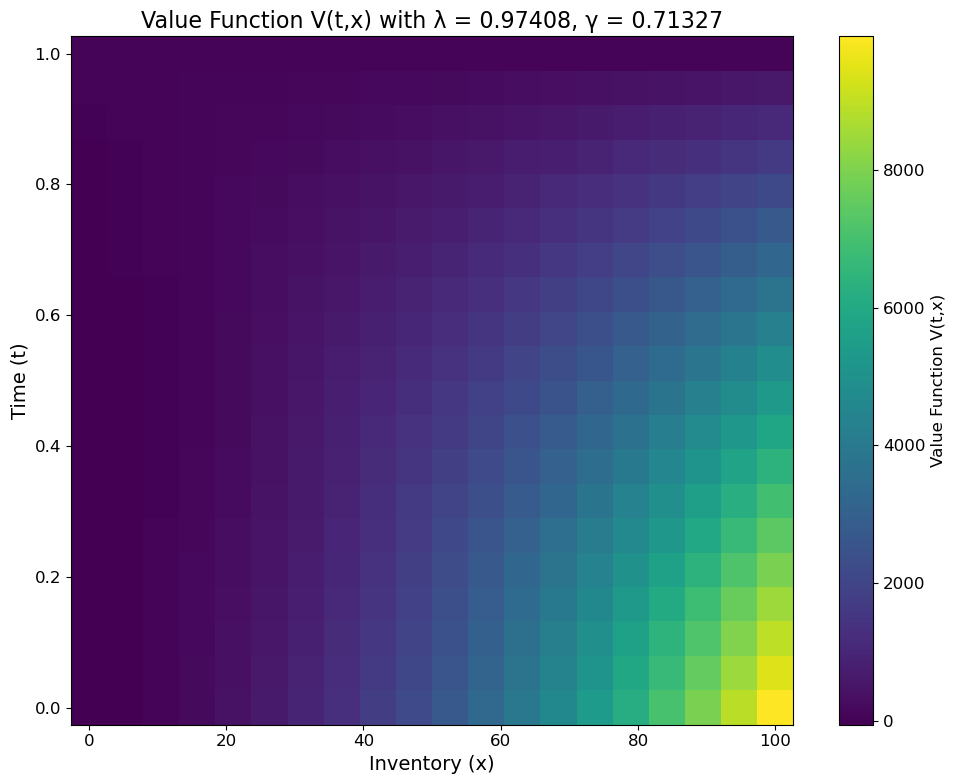

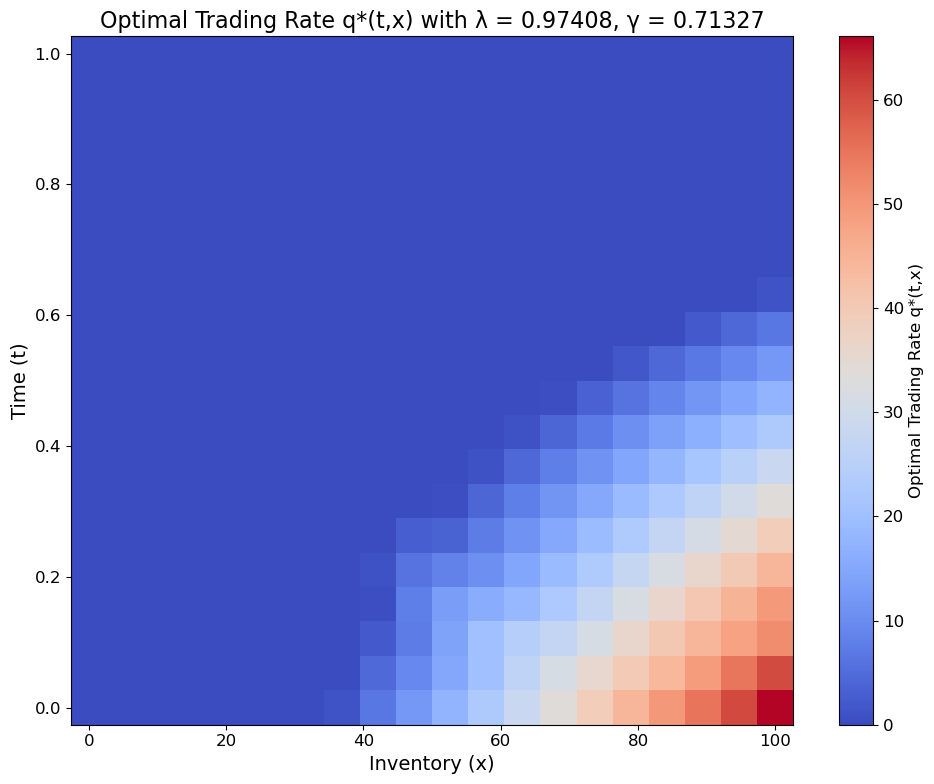

Starting finetuning phase with bilevel optimization...


Finetuning: 100%|██████████| 1000/1000 [01:18<00:00, 12.82it/s, res_loss=2.273e+07, term_loss=1.995e+07, data_loss=0.000e+00, λ=1.29502, γ=0.72435]


Finetuning completed
Final parameters: λ = 1.31257, γ = 0.72273


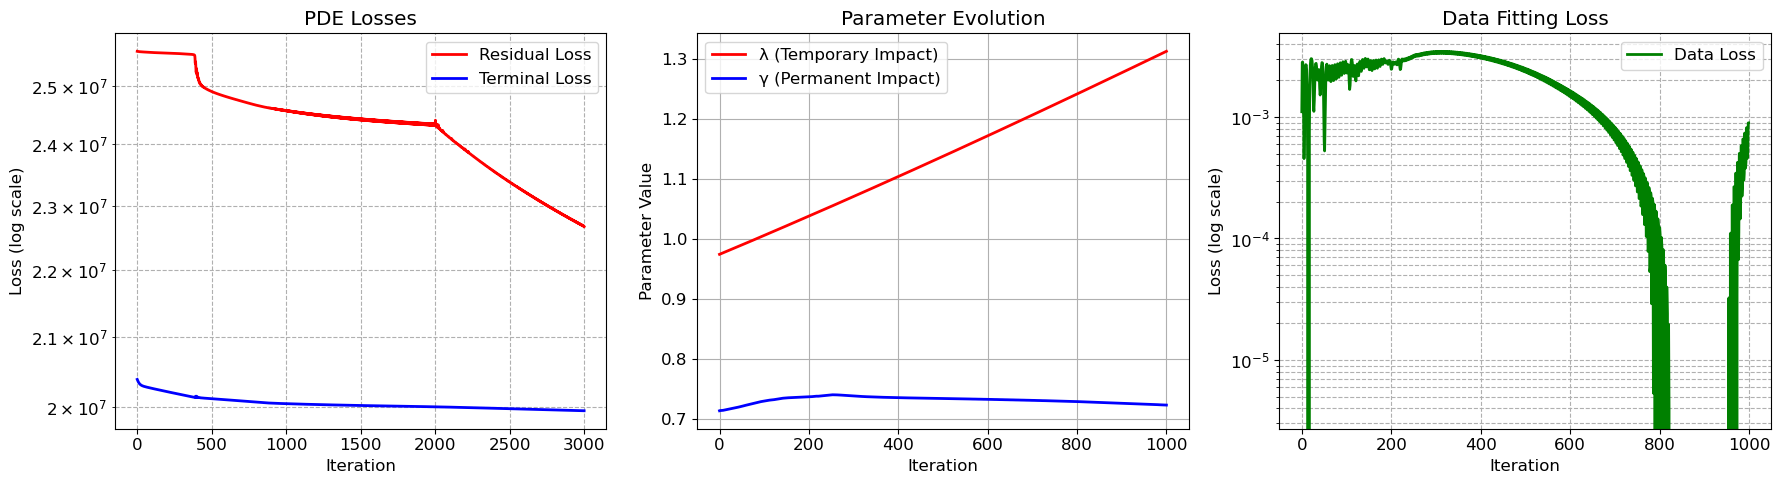


After BILO finetuning:


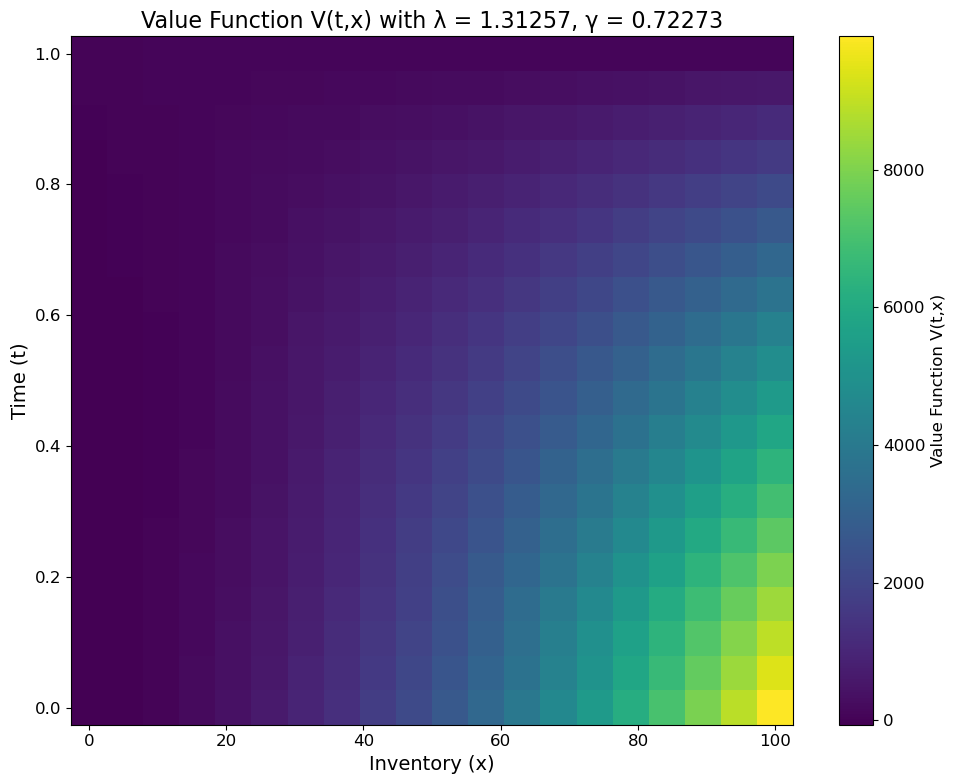

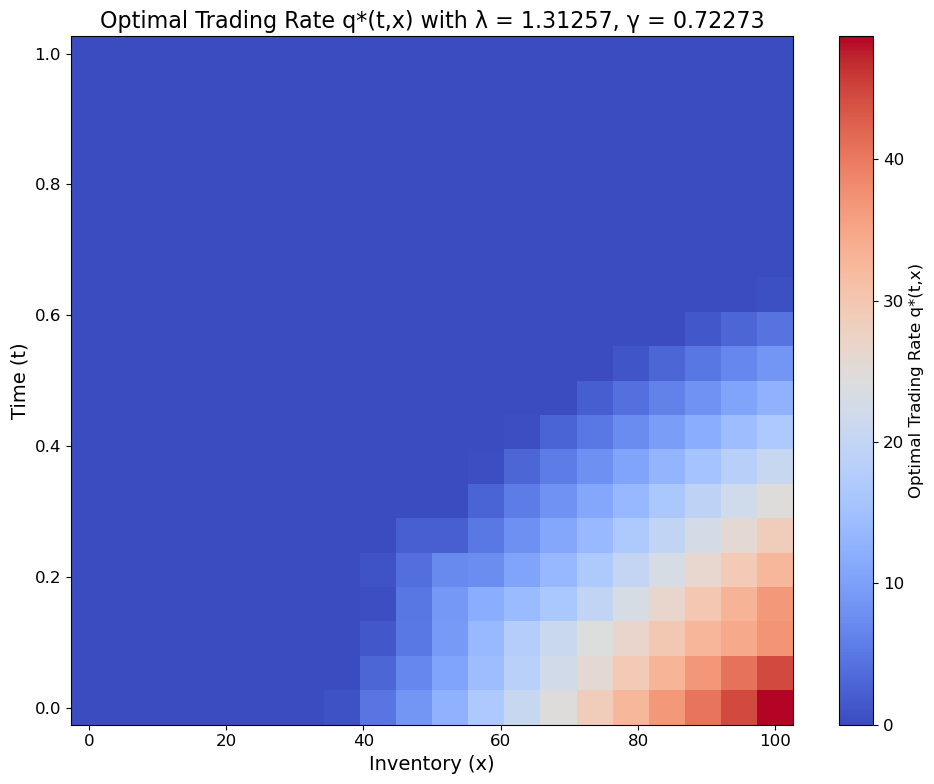

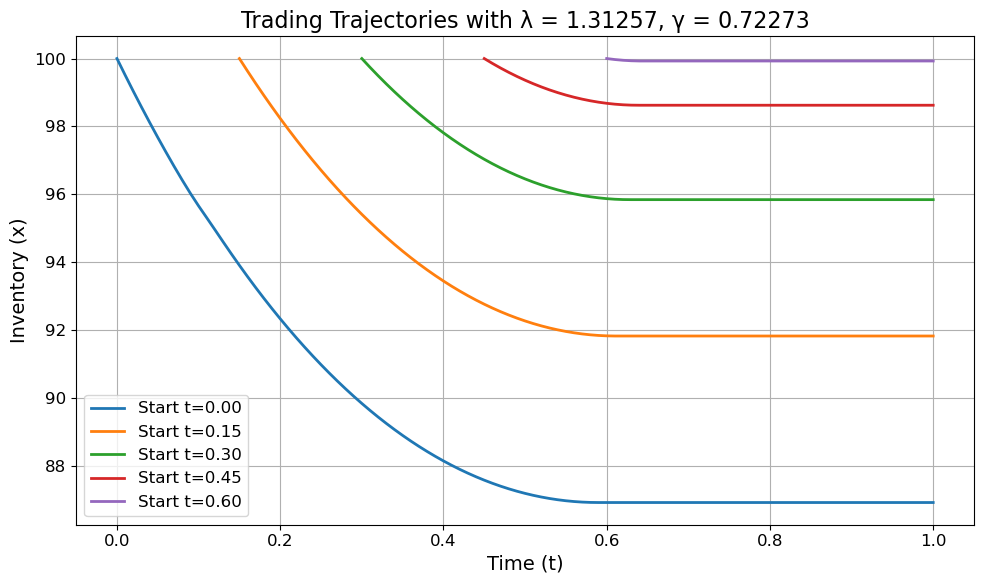


Refining parameters with DDQL...

Refining parameters with DDQL...
Initial BILO parameters: λ = 1.31257, γ = 0.72273
Starting DDQL training for parameter refinement...


DDQL Training:   3%|▎         | 3/100 [00:00<00:03, 27.23it/s, reward=-1758.002, λ=1.32224, γ=0.79561, ε=0.383]/var/folders/h2/f9z5vqd935g1b0rvdfm8pv5h0000gn/T/ipykernel_53555/2483605819.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.cat([torch.tensor(e.state, device=self.device) for e in experiences])
/var/folders/h2/f9z5vqd935g1b0rvdfm8pv5h0000gn/T/ipykernel_53555/2483605819.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.cat([torch.tensor(e.next_state, device=self.device) for e in experiences])
DDQL Training:  15%|█▌        | 15/100 [00:00<00:03, 24.96it/s, reward=-1723.837, λ=1.18682, γ=0.74636, ε=0.050]

Episode 10/100, Avg Reward: -1781.093, λ: 1.35589, γ: 0.84562, ε: 0.094


DDQL Training:  24%|██▍       | 24/100 [00:00<00:03, 24.23it/s, reward=-1846.341, λ=1.29785, γ=1.09973, ε=0.050]

Episode 20/100, Avg Reward: -1759.046, λ: 1.38169, γ: 0.94077, ε: 0.050


DDQL Training:  33%|███▎      | 33/100 [00:01<00:02, 24.74it/s, reward=-1879.817, λ=1.37588, γ=1.16046, ε=0.050]

Episode 30/100, Avg Reward: -1861.646, λ: 1.33723, γ: 1.27744, ε: 0.050


DDQL Training:  45%|████▌     | 45/100 [00:01<00:02, 24.92it/s, reward=-1855.479, λ=1.38118, γ=1.06514, ε=0.050]

Episode 40/100, Avg Reward: -1885.262, λ: 1.34864, γ: 1.13167, ε: 0.050


DDQL Training:  54%|█████▍    | 54/100 [00:02<00:01, 23.91it/s, reward=-1867.975, λ=1.39042, γ=1.09401, ε=0.050]

Episode 50/100, Avg Reward: -1860.802, λ: 1.36575, γ: 1.11660, ε: 0.050


DDQL Training:  63%|██████▎   | 63/100 [00:02<00:01, 24.45it/s, reward=-1836.388, λ=1.28360, γ=1.08626, ε=0.050]

Episode 60/100, Avg Reward: -1858.732, λ: 1.23321, γ: 1.06345, ε: 0.050


DDQL Training:  72%|███████▏  | 72/100 [00:03<00:01, 24.35it/s, reward=-1838.669, λ=1.48487, γ=1.00809, ε=0.050]

Episode 70/100, Avg Reward: -1832.314, λ: 1.35087, γ: 0.87287, ε: 0.050


DDQL Training:  84%|████████▍ | 84/100 [00:03<00:00, 24.38it/s, reward=-1821.318, λ=1.62133, γ=0.86596, ε=0.050]

Episode 80/100, Avg Reward: -1835.515, λ: 1.57565, γ: 0.94860, ε: 0.050


DDQL Training:  93%|█████████▎| 93/100 [00:03<00:00, 24.79it/s, reward=-1854.315, λ=1.72180, γ=1.00489, ε=0.050]

Episode 90/100, Avg Reward: -1830.348, λ: 1.67781, γ: 0.95891, ε: 0.050


DDQL Training: 100%|██████████| 100/100 [00:04<00:00, 24.43it/s, reward=-1897.626, λ=1.80159, γ=1.15438, ε=0.050]


Episode 100/100, Avg Reward: -1863.875, λ: 1.80159, γ: 1.15438, ε: 0.050


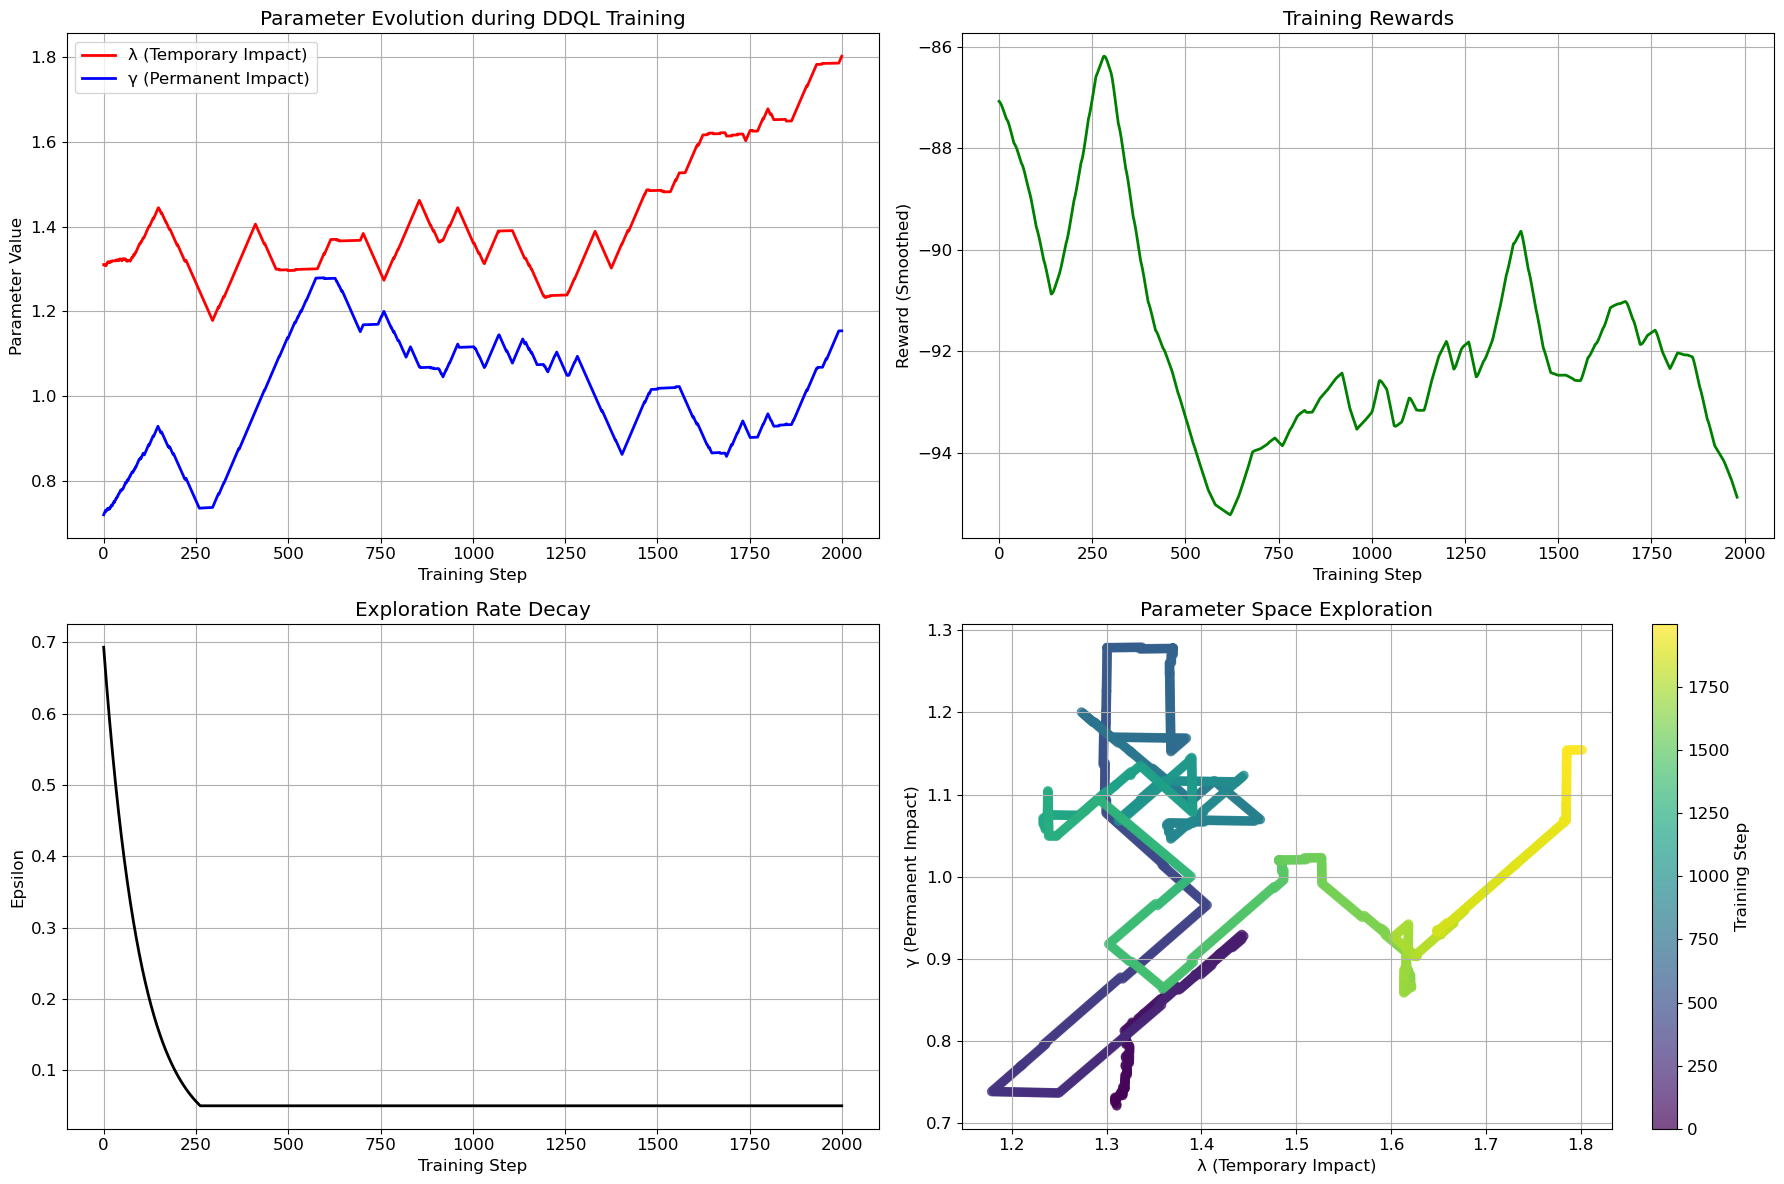

DDQL training completed.
Final parameters: λ = 1.80159, γ = 1.15438

Parameter Refinement Results:
BILO:      λ = 1.31257, γ = 0.72273
BILO+DDQL: λ = 1.80159, γ = 1.15438
Change:    Δλ = 0.48902, Δγ = 0.43165

Comparing trading strategies:

Comparing trading strategies with parameters:
BILO:      λ = 1.31257, γ = 0.72273
BILO+DDQL: λ = 1.80159, γ = 1.15438
Initialized with λ = 1.31257, γ = 0.72273
Initialized with λ = 1.80159, γ = 1.15438
BILO model check: λ = 1.55090, γ = 1.11843
DDQL model check: λ = 1.95435, γ = 1.42841
Generating BILO trading trajectory...
Generating DDQL trading trajectory...

Execution Cost Comparison:
BILO Cost: 626.38
BILO+DDQL Cost: 213.83
Cost Reduction: 65.86% (412.55 units)


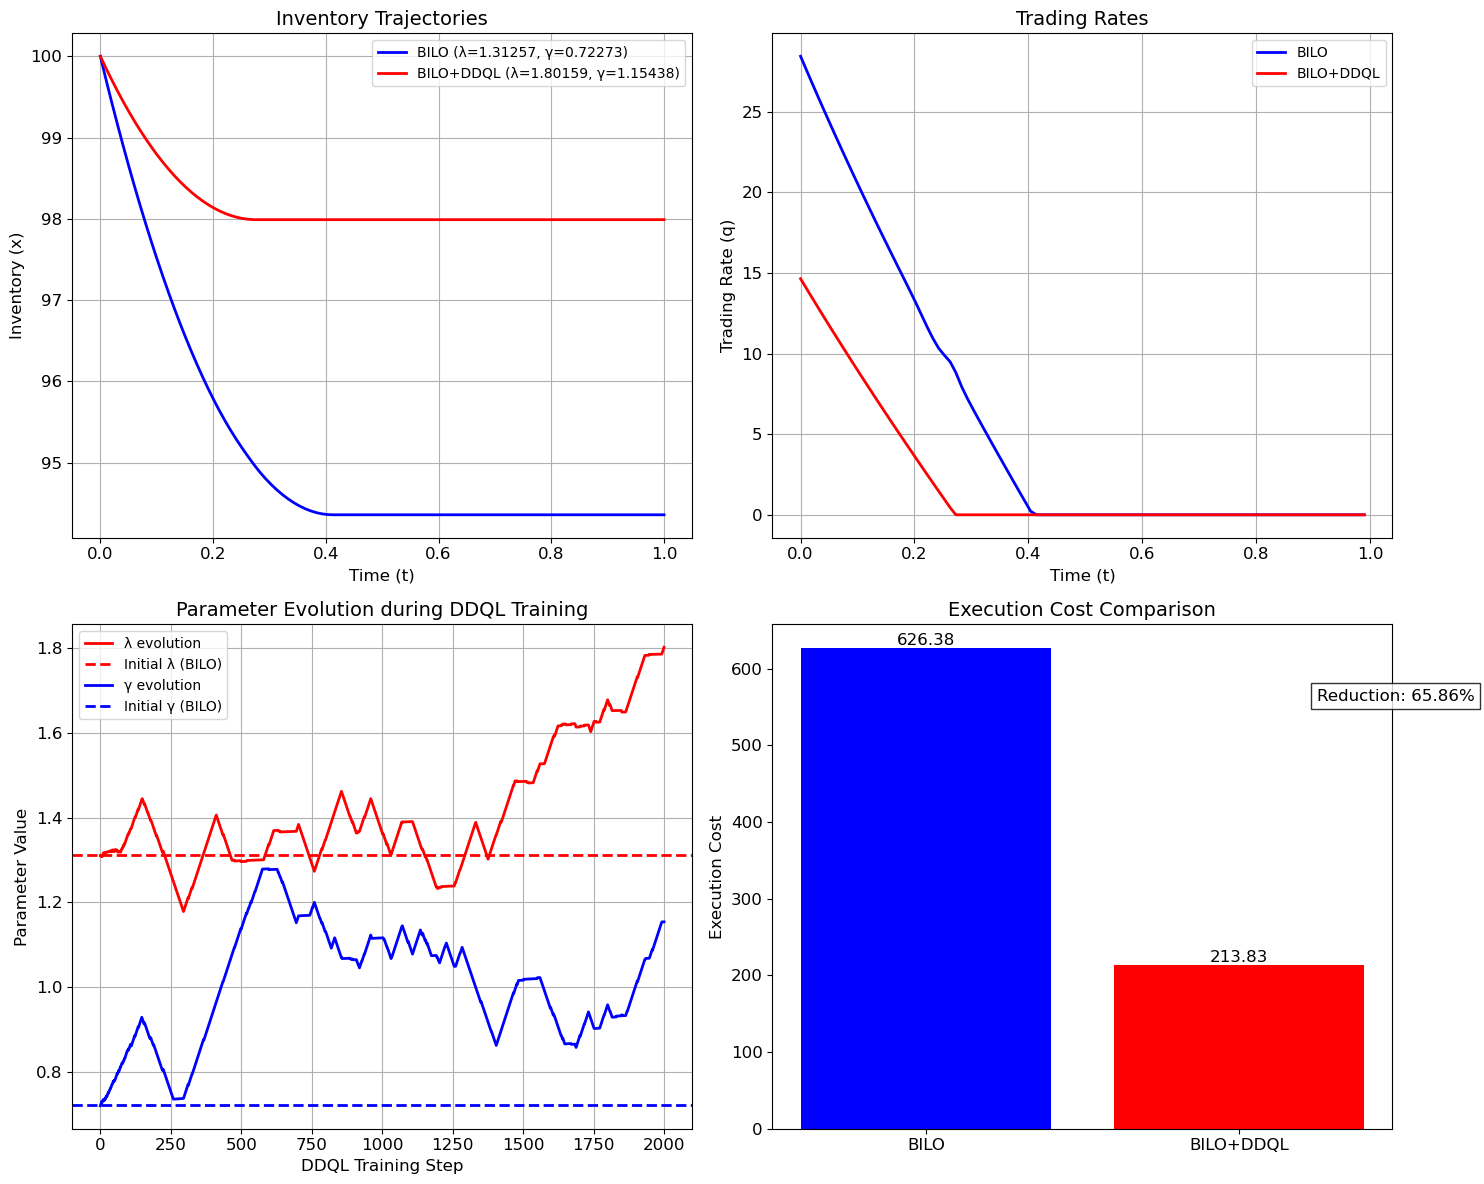


Advanced execution strategies after BILO+DDQL:
Initialized with λ = 1.31257, γ = 0.72273
Initialized with λ = 1.80159, γ = 1.15438


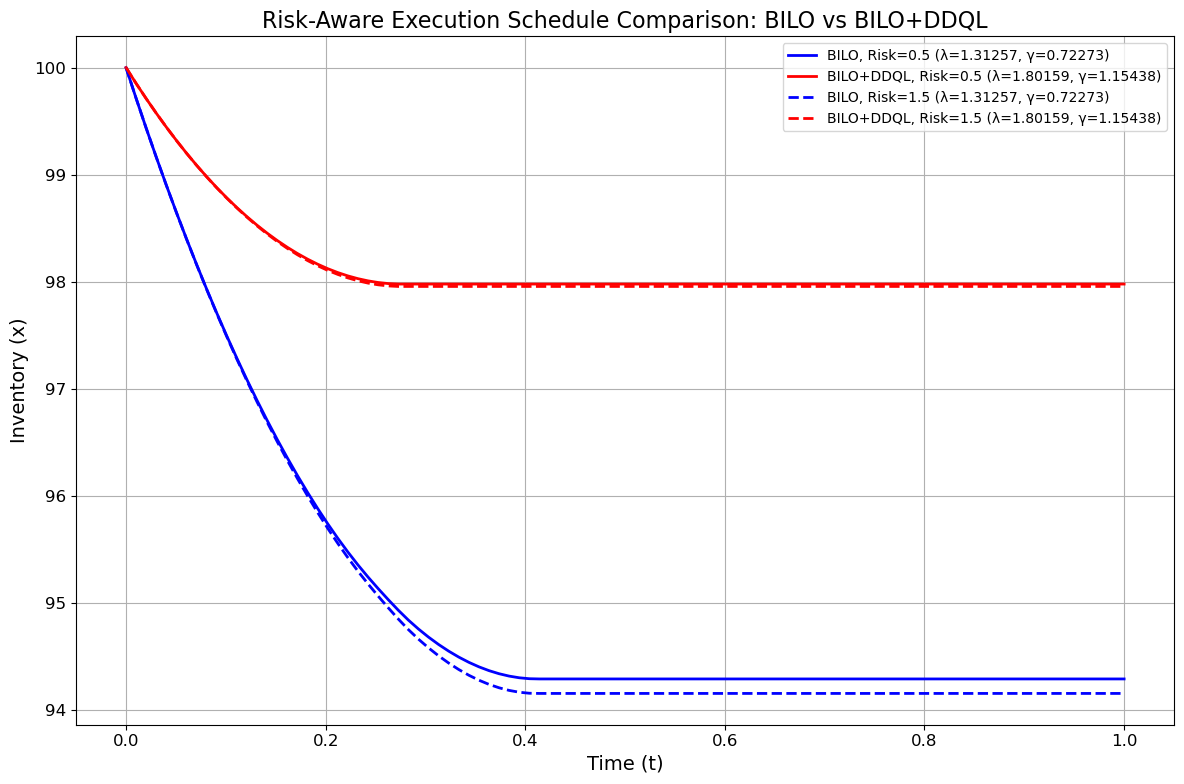


Final Parameter Estimates:
BILO Initial:  λ = 0.50000, γ = 0.03984
BILO Final:    λ = 1.31257, γ = 0.72273
BILO+DDQL:     λ = 1.80159, γ = 1.15438


In [29]:
def run_experiment_with_ddql(x0=100.0, T=1.0, S0=100.0, alpha=1.0, seed=42):
    """
    Run an experiment to identify parameters in the Almgren-Chriss model
    using both BILO and DDQL approaches
    """
    # Set random seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    print("\n" + "="*80)
    print(f"Running parameter identification experiment for Almgren-Chriss model")
    print("="*80)
    
    # 1. Create the PDE problem
    pde = AlmgrenChrissPDE(T=T, x0=x0, S0=S0, alpha=alpha)
    
    # 2. Generate dataset
    dataset = pde.generate_dataset(N_res=1500, N_dat=200, N_boundary=80, N_test=400)
    pde.to_device(device)
    
    # 3. Create value function network
    value_net = ValueFunctionNet(depth=4, width=128).to(device)
    
    # 4. Estimate initial parameters using heuristics
    # For Almgren-Chriss model, a reasonable heuristic is:
    # - Temporary impact (λ) ~= market spread / 2 * daily volume
    # - Permanent impact (γ) ~= average price impact of 1% of daily volume
    
    # Simulated market data assumptions (would be real market data in practice)
    avg_spread_bps = 5  # 5 basis points spread
    daily_volume_pct = 0.1  # Trading 10% of daily volume
    market_volatility = 0.2  # Annual volatility
    
    # Convert to initial parameter estimates
    daily_vol_factor = market_volatility / np.sqrt(252)
    init_lambda = (avg_spread_bps / 10000) * S0 / daily_volume_pct
    init_gamma = daily_vol_factor * S0 * np.sqrt(daily_volume_pct) / 10
    
    print(f"Market-based initial estimates: λ = {init_lambda:.5f}, γ = {init_gamma:.5f}")
    
    # 5. Create BILO optimization with DDQL extension
    bilo = BILOwithDDQL(value_net, pde, init_lambda=init_lambda, init_gamma=init_gamma).to(device)
    
    # 6. Pretrain the network
    bilo.pretrain(max_iter=2000, lr=5e-4, weight_decay=1e-6)
    
    # 7. Plot initial value function and trading rate
    print("\nAfter pretraining:")
    bilo.plot_value_function()
    bilo.plot_optimal_trading_rate()
    
    # 8. Fine-tune with bilevel optimization
    bilo.finetune(max_iter=1000, lr_net=1e-4, lr_params=5e-4, weight_decay=1e-6)
    
    # 9. Plot training history
    bilo.plot_losses()
    
    # 10. Plot results after BILO
    print("\nAfter BILO finetuning:")
    bilo.plot_value_function()
    bilo.plot_optimal_trading_rate()
    bilo.plot_trading_trajectories()
    
    # 11. Further refine parameters with DDQL
    print("\nRefining parameters with DDQL...")
    ddql_results = bilo.ddql_refine_parameters(num_episodes=100)
    
    # 12. Compare trading strategies
    print("\nComparing trading strategies:")
    comparison = bilo.compare_trading_strategies()
    
    # 13. Plot advanced execution strategies
    print("\nAdvanced execution strategies after BILO+DDQL:")
    bilo.plot_optimized_schedules_comparison()  # Updated method name
    
    # 14. Report final results
    lambda_val, gamma_val = bilo.get_lambda_gamma()
    
    # Updated to match the new dictionary structure
    print("\nFinal Parameter Estimates:")
    print(f"BILO Initial:  λ = {init_lambda:.5f}, γ = {init_gamma:.5f}")
    print(f"BILO Final:    λ = {ddql_results['bilo_params']['lambda']:.5f}, γ = {ddql_results['bilo_params']['gamma']:.5f}")
    print(f"BILO+DDQL:     λ = {ddql_results['ddql_params']['lambda']:.5f}, γ = {ddql_results['ddql_params']['gamma']:.5f}")
    
    results = {
        'estimated_lambda': lambda_val.item(),
        'estimated_gamma': gamma_val.item(),
        'bilo_lambda': ddql_results['bilo_params']['lambda'],
        'bilo_gamma': ddql_results['bilo_params']['gamma'],
        'ddql_lambda': ddql_results['ddql_params']['lambda'],
        'ddql_gamma': ddql_results['ddql_params']['gamma'],
        'ddql_results': ddql_results,
        'comparison': comparison
    }
    
    return bilo, results
# Run the experiment with DDQL
if __name__ == "__main__":
    # Problem parameters
    X0 = 100.0            # Initial inventory
    T = 1.0               # Time horizon
    S0 = 100.0            # Initial price
    ALPHA = 1.0           # Terminal cost coefficient
    
    # Run experiment with BILO + DDQL
    bilo_model, results = run_experiment_with_ddql(
        x0=X0,
        T=T,
        S0=S0,
        alpha=ALPHA,
        seed=42
    )